# Differential Expression of Genes in the Brain

In [1]:
import os
import random
import datetime
import time
import math
import numpy as np
from numpy import linalg as LA
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import scipy.stats as stats
!pip install statsmodels
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.stats.diagnostic import het_white
import statsmodels.formula.api as smf
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from itertools import combinations
from statsmodels.stats.multitest import multipletests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 70.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 KB 43.7 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install pyreadr
import pyreadr
urllib.request.urlretrieve("https://raw.githubusercontent.com/unique-subedi/gene-expression/main/data/brain.rda", "brain.rda")
brain = pyreadr.read_r("brain.rda")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.3/363.3 KB 26.2 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install qnorm
import qnorm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 92.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 41.4 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [4]:
expression = pd.DataFrame(brain["expression"])
genes = pd.DataFrame(brain["genes"])
samples = pd.DataFrame(brain["samples"])

In [5]:
# Select bacterial controls
genes.at["AFFX-BioDn-3_at", 'chrom'] = float("Nan")
genes_control = genes[['AFFX' in s for s in genes.index]]
genes_control = genes_control[['HUM' not in s for s in genes_control.index]]
genes_control = genes_control[['hum' not in s for s in genes_control.index]]
genes_bac_index = genes_control[genes_control.chrom.isnull() & genes_control.sym.isnull()].index
genes_hum_index = [x for x in genes.index if x not in genes_bac_index]

# Microarray level normalization: Detected microarray-wise effects for both Michigan and Irvine
# We ideally want very similar distribution(mean, std) for each microarray. 
# This may not remove lab effects/heterogeneity across labs
mean_bac_exp = expression[genes_bac_index].mean(axis=1)
std_bac_exp = expression[genes_bac_index].std(axis=1)
expression_norm =  (expression - mean_bac_exp.values[:, None]).divide(std_bac_exp, axis=0)
express_norm_samp = pd.concat([expression_norm, samples], axis=1)

In [6]:
# Dictionary which maps each gene to the corresponding probe sets
genes_sym = genes[genes.sym.notnull()]
unique_genes = genes_sym["sym"].unique()
gene_to_probe_set = {}

for gene in unique_genes:
  gene_to_probe_set[gene] = genes_sym.index[genes_sym.sym == gene].tolist()

## Executive Summary

This report recommends genes that should be further investigated in a confirmatory analysis for being differentially expressed between sex and brain tissue regions.    

The key results can be summarized as follows:

1.  Sex has a statistically significant effect on gene expression. Our analysis appears reliable and recommends that the following genes be further investigated for the confirmatory analysis: `RPS4Y1`, `DDX3Y`, `XIST`, `KDM5D`, `USP9Y`, `TTTY15`, `UTY`. 

2. The tissue effect, if exists, is weak both in an absolute sense and in a relative sense compared to the sex effect. For many probe sets/individuals, the unwanted variations (measurement noise, broadly) are large enough to dominate the tissue effect. Accordingly, our recommendations for genes that are differentially expressed between tissue regions is less reliable.


## Data Overview and Processing

In the study, there are 10 patients, 5 males and 5 females, indicated by patient_01 to patient_10. For each patient, log expressions for 12,600 probe sets (some represent human control or bacteria control probe sets) are collected in 3 regions of the brain, namely A.C. cortex, Cerebellum and D.L.P.F. cortex. This process is replicated across 3 labs: UC Davis, UC Irvine and University of Michigan. Davis and Michigan labs measure gene expressions using both chip versions (v1 and v2), while Irvine lab only uses chip version v2. Ideally, we have 10 x 3 = 30 patient-region pairs for each lab. While this is true for Irvine and Michigan, we only have 24 pairs for Davis.

We categorize the probe sets following the convention below.

- Bacteria control probe sets are exactly those satisfying all the following criteria: (1) contains `AFFX`; (2) does not contain `HUM` (or `hum`); (3) has the value `NA` for both chromosome and symbol
- Human control probe sets are exactly those satisfying all the following criteria: (1) contains `AFFX`; (2) is not a bacteria control probe set. This is used as a sanity check (i.e., our model should not output genes corresponding to these probe sets [`ACTB`, `GAPDH`, `STAT1`, `TFRC`] as differentially expressed)
- "True gene" probe sets: all probe sets which are not (bacteria or human) control probe sets

There are 44 bacteria control probe sets, 23 human control probe sets and 12,533 true gene probe sets. In addition, it is important to note that one probe set can correspond to multiple genes. Since our ultimate goal is to recommend differentially expressed genes and the analysis is done for each probe set, we follow a conservative approach of selecting the worst-performing probe set for each gene.

Finally, some true gene probe sets have NAs as their symbols. For simplicity, we remove these genes from our analyses.



## Non-Biological Variability in Gene Expression

This section investigates the presence of non-biological variability in gene expression, which needs to be eliminated in order to obtain more convincing results. A simple boxplot of log expressions for each microarray (corresponding to one person-region-lab triplet) indicates a presence of microarray and lab effects. With regard to lab effect, we tend to see lower gene expression values for Michigan and higher gene expression values for Irvine.

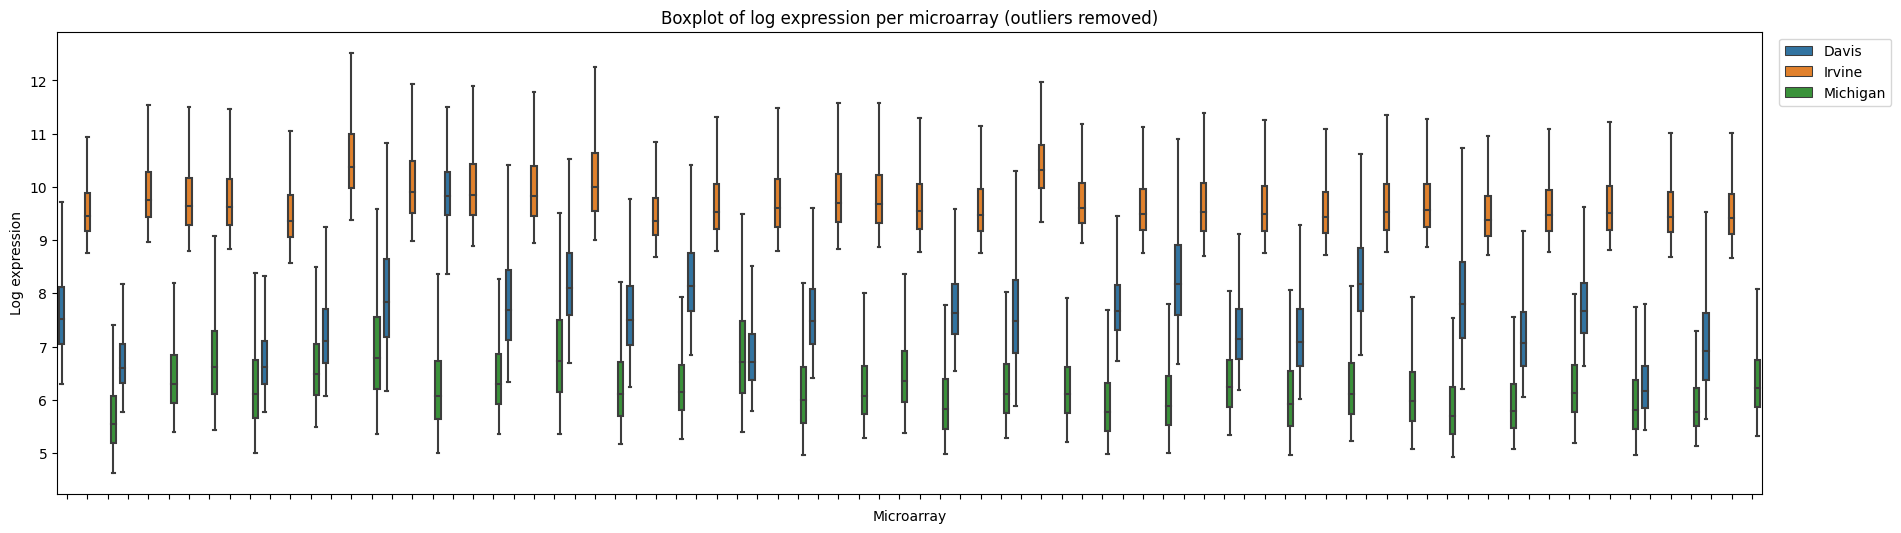

In [7]:
t = pd.melt(expression.T)
t = pd.merge(t, samples[['lab']], left_on='variable', right_index = True)

fig, ax = plt.subplots(1, 1, figsize=(22, 6), sharey = "all")
sns.boxplot(x="variable", y="value", data=t, hue = 'lab', showfliers = False)
ax.set_xlabel("Microarray")
ax.set_ylabel("Log expression")
ax.set(xticklabels=[])
ax.title.set_text('Boxplot of log expression per microarray (outliers removed)')
ax.legend(bbox_to_anchor=(1.08, 1))

Now, we can zoom into Davis and Michigan, the labs with both chip versions, to see if there is any apparent chip version effect. The plots below compare the log expressions of microarrays corresponding to chip version v1 and v2 for Davis and Michigan labs (each boxplot represents one microarray). Note that Irvine lab only uses chip version v2. As seen on the plots below, there seems to be some chip version effect in both labs, even though the effect is more pronounced in the Davis lab.


Text(0.5, 0.98, 'Davis microarray boxplot for each chip version (outliers removed)')

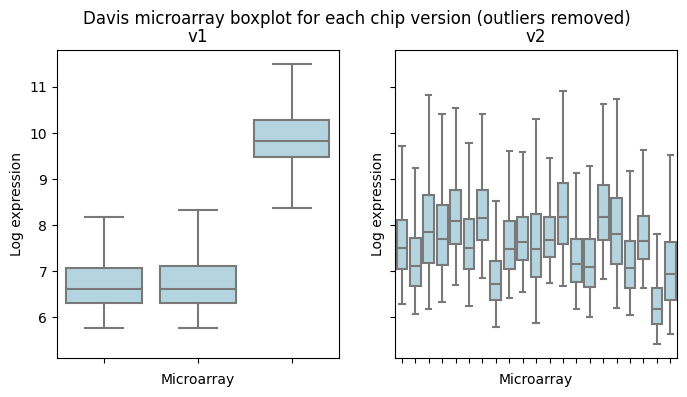

In [8]:
t = pd.melt(expression.T)
t = pd.merge(t, samples[['lab', 'chip.version']], left_on='variable', right_index = True)

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey = "all")
c = 0

for chip_version in ['v1', 'v2']:
  temp = t[(t['lab'] == 'Davis') & (t['chip.version'] == chip_version)]
  sns.boxplot(x="variable", y="value", data=temp, showfliers = False, ax = axs[c], color = 'lightblue')
  axs[c].set_xlabel("Microarray")
  axs[c].set_ylabel("Log expression")
  axs[c].set(xticklabels=[])
  axs[c].title.set_text(chip_version)
  c += 1
plt.suptitle('Davis microarray boxplot for each chip version (outliers removed)')

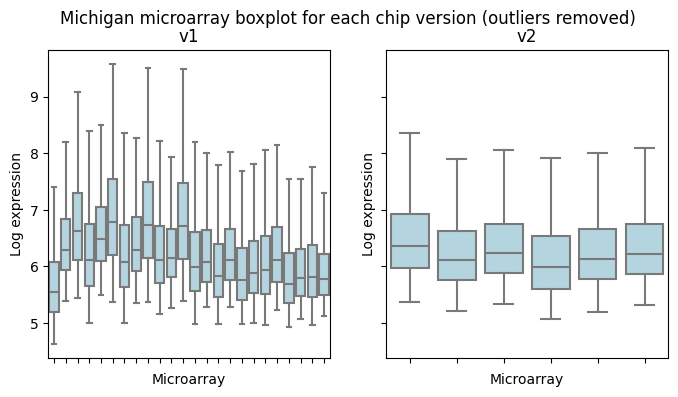

In [9]:
t = pd.melt(expression.T)
t = pd.merge(t, samples[['lab', 'chip.version']], left_on='variable', right_index = True)

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey = "all")
c = 0

for chip_version in ['v1', 'v2']:
  temp = t[(t['lab'] == 'Michigan') & (t['chip.version'] == chip_version)]
  sns.boxplot(x="variable", y="value", data=temp, showfliers = False, ax = axs[c], color = 'lightblue')
  axs[c].set_xlabel("Microarray")
  axs[c].set_ylabel("Log expression")
  axs[c].set(xticklabels=[])
  axs[c].title.set_text(chip_version)
  c += 1
plt.suptitle('Michigan microarray boxplot for each chip version (outliers removed)');

It is also interesting to see how the log expression for each patient-region pair varies across lab locations. As there are more than 12,000 probe sets, we select 3 of them at random. The line plots below show that the scales of log expressions for probe set `38654_at`, `34714_at` and `37208_at` differ across lab locations for each patient-region index.

Text(0.5, 0.98, 'Log expression for each patient-region combination for selected probe sets')

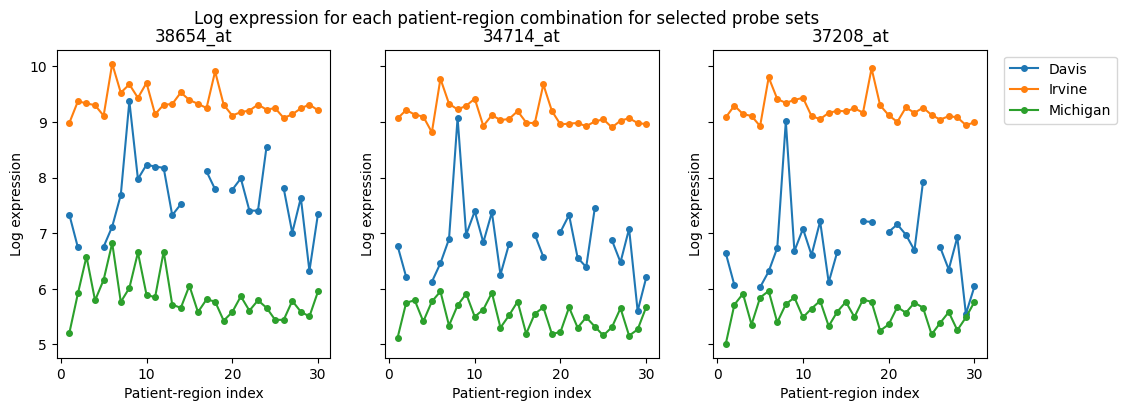

In [10]:
davis = expression[expression.index.str.contains('_D_')]
irvine = expression[expression.index.str.contains('_I_')]
michigan = expression[expression.index.str.contains('_M_')]
davis.index = [x.replace('_D','').replace('_1','').replace('_2','') for x in davis.index]
irvine.index = [x.replace('_I','').replace('_1','').replace('_2','') for x in irvine.index]
michigan.index = [x.replace('_M','').replace('_1','').replace('_2','') for x in michigan.index]

random.seed(2022)
random_selections = random.sample(range(len(genes_hum_index)), 3)

fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey = "all")
c = 0
for random_selection in random_selections:
    var_name = genes_hum_index[random_selection]
    temp = pd.merge(irvine[[var_name]], davis[[var_name]], how = 'left', left_index = True, right_index = True) \
    .merge(michigan[[var_name]], how = 'left', left_index = True, right_index = True)
    axs[c].plot(np.arange(1,31), temp[var_name + '_y'], marker = 'o', markersize = 4, label = 'Davis')
    axs[c].plot(np.arange(1,31), temp[var_name + '_x'], marker = 'o', markersize = 4, label = 'Irvine')
    axs[c].plot(np.arange(1,31), temp[var_name], marker = 'o', markersize = 4, label = 'Michigan')
    if c == 2:
        axs[c].legend(bbox_to_anchor=(1.5, 1), loc="upper right")
    axs[c].set_xlabel('Patient-region index');
    axs[c].set_ylabel('Log expression');
    axs[c].title.set_text(var_name)
    c += 1

plt.suptitle('Log expression for each patient-region combination for selected probe sets')

## Bacteria Normalization

In an attempt to combat some of these undesirable non-biological effects, we normalized the probe expressions of each microarray using the following procedure: 

1) Compute $\mu_{\text{bac}}$: the mean expression across bacterial control probe sets in the microarray.
2) Compute $\sigma_{\text{bac}}$: the standard deviation of the expressions across bacterial probe sets in the microarray.
3) For each probe set in the microarray, subtract $\mu_{\text{bac}}$ from its expression and then divide by $\sigma_{\text{bac}}$. 

At a high-level, the idea is to standardize the values in a microarray by the expressions of the bacterial control. Since the bacterial controls are unrelated to humans, they serve as a way to capture possible microarray, lab, and chip version effects. This procedure, termed bacteria normalization, was performed for each microarray seperately. 

Now, we can recreate the above plots using the normalized log expression, and visually conclude that some (but not all) of the unwanted variations have been removed. While we have removed the variations for Irvine and Michigan reasonably well, the same does not apply to Davis, as shown clearly in the line plots.

Text(0.5, 0.98, 'Davis microarray boxplot for each chip version (bacteria-normalized; outliers removed)')

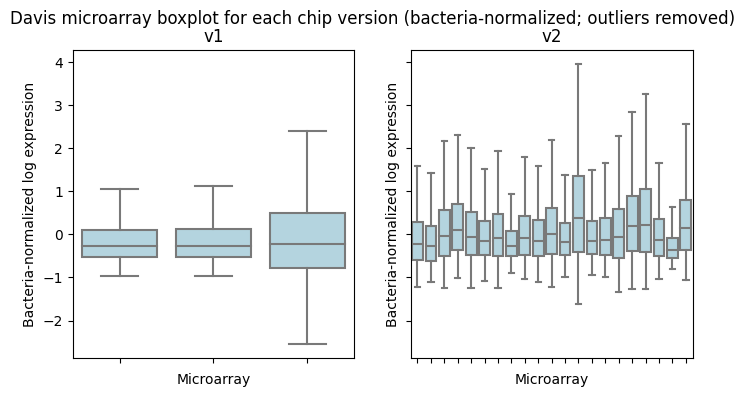

In [11]:
t = pd.melt(expression_norm.T)
t = pd.merge(t, samples[['lab', 'chip.version']], left_on='variable', right_index = True)

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey = "all")
c = 0

for chip_version in ['v1', 'v2']:
  temp = t[(t['lab'] == 'Davis') & (t['chip.version'] == chip_version)]
  sns.boxplot(x="variable", y="value", data=temp, showfliers = False, ax = axs[c], color = 'lightblue')
  axs[c].set_xlabel("Microarray")
  axs[c].set_ylabel("Bacteria-normalized log expression")
  axs[c].set(xticklabels=[])
  axs[c].title.set_text(chip_version)
  c += 1

plt.suptitle('Davis microarray boxplot for each chip version (bacteria-normalized; outliers removed)')

Text(0.5, 0.98, 'Michigan microarray boxplot for each chip version (bacteria-normalized; outliers removed)')

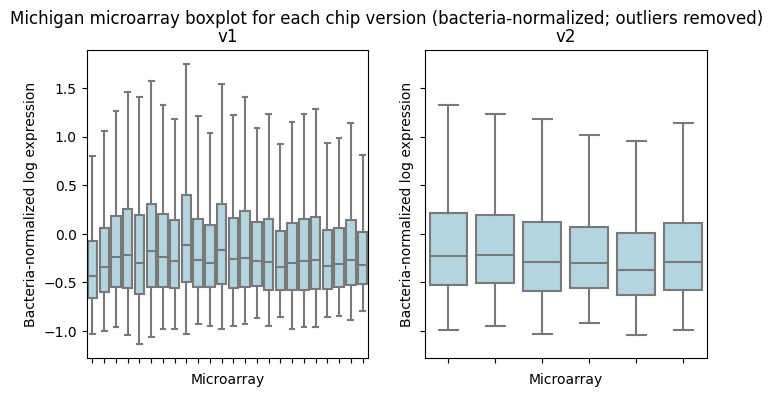

In [12]:
t = pd.melt(expression_norm.T)
t = pd.merge(t, samples[['lab', 'chip.version']], left_on='variable', right_index = True)

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey = "all")
c = 0

for chip_version in ['v1', 'v2']:
  temp = t[(t['lab'] == 'Michigan') & (t['chip.version'] == chip_version)]
  sns.boxplot(x="variable", y="value", data=temp, showfliers = False, ax = axs[c], color = 'lightblue')
  axs[c].set_xlabel("Microarray")
  axs[c].set_ylabel("Bacteria-normalized log expression")
  axs[c].set(xticklabels=[])
  axs[c].title.set_text(chip_version)
  c += 1

plt.suptitle('Michigan microarray boxplot for each chip version (bacteria-normalized; outliers removed)')

Text(0.5, 0.98, 'Bacteria-normalized log expression for each patient-region combination for selected probe sets')

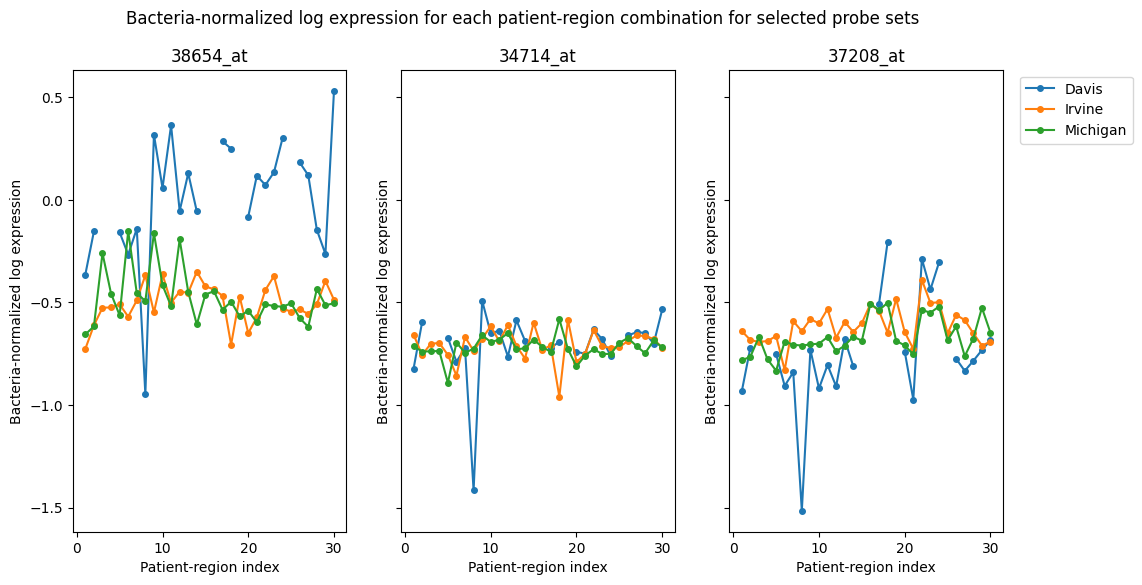

In [13]:
davis = expression_norm[expression_norm.index.str.contains('_D_')]
irvine = expression_norm[expression_norm.index.str.contains('_I_')]
michigan = expression_norm[expression_norm.index.str.contains('_M_')]
davis.index = [x.replace('_D','').replace('_1','').replace('_2','') for x in davis.index]
irvine.index = [x.replace('_I','').replace('_1','').replace('_2','') for x in irvine.index]
michigan.index = [x.replace('_M','').replace('_1','').replace('_2','') for x in michigan.index]

random.seed(2022)
random_selections = random.sample(range(len(genes_hum_index)), 3)

fig, axs = plt.subplots(1, 3, figsize=(12, 6), sharey = "all")
c = 0
for random_selection in random_selections:
    var_name = genes_hum_index[random_selection]
    temp = pd.merge(irvine[[var_name]], davis[[var_name]], how = 'left', left_index = True, right_index = True) \
    .merge(michigan[[var_name]], how = 'left', left_index = True, right_index = True)
    axs[c].plot(np.arange(1,31), temp[var_name + '_y'], marker = 'o', markersize = 4, label = 'Davis')
    axs[c].plot(np.arange(1,31), temp[var_name + '_x'], marker = 'o', markersize = 4, label = 'Irvine')
    axs[c].plot(np.arange(1,31), temp[var_name], marker = 'o', markersize = 4, label = 'Michigan')
    if c == 2:
        axs[c].legend(bbox_to_anchor=(1.5, 1), loc="upper right")
    axs[c].set_xlabel('Patient-region index');
    axs[c].set_ylabel('Bacteria-normalized log expression');
    axs[c].title.set_text(var_name)
    c += 1

plt.suptitle('Bacteria-normalized log expression for each patient-region combination for selected probe sets')

Finally, we can compare our bacteria normalization method with quantile normalization, which is arguably the most widely used normalization method for microarray data. It is worth noting that this method does not require any control values. We re-generate the above line plots after changing the normalization method to quantile normalization. 

It can be seen that our method seems to be somewhat comparable in removing unwanted variation as compared to quantile normalization, thus for the remainder of this report we will stick to using bacteria normalization.

Text(0.5, 0.98, 'Quantile-normalized log expression for each patient-region combination for selected probe sets')

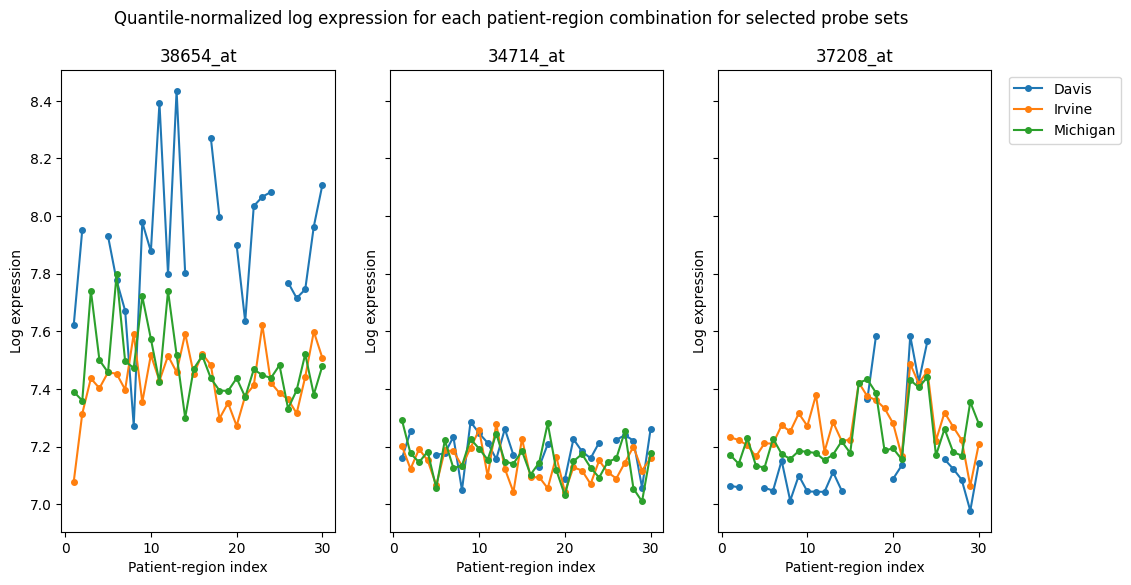

In [14]:
expression_qnorm = qnorm.quantile_normalize(expression, axis=0)
davis = expression_qnorm[expression_qnorm.index.str.contains('_D_')]
irvine = expression_qnorm[expression_qnorm.index.str.contains('_I_')]
michigan = expression_qnorm[expression_qnorm.index.str.contains('_M_')]
davis.index = [x.replace('_D','').replace('_1','').replace('_2','') for x in davis.index]
irvine.index = [x.replace('_I','').replace('_1','').replace('_2','') for x in irvine.index]
michigan.index = [x.replace('_M','').replace('_1','').replace('_2','') for x in michigan.index]

random.seed(2022)
random_selections = random.sample(range(len(genes_hum_index)), 3)

fig, axs = plt.subplots(1, 3, figsize=(12, 6), sharey = "all")
c = 0
for random_selection in random_selections:
    var_name = genes_hum_index[random_selection]
    temp = pd.merge(irvine[[var_name]], davis[[var_name]], how = 'left', left_index = True, right_index = True) \
    .merge(michigan[[var_name]], how = 'left', left_index = True, right_index = True)
    axs[c].plot(np.arange(1,31), temp[var_name + '_y'], marker = 'o', markersize = 4, label = 'Davis')
    axs[c].plot(np.arange(1,31), temp[var_name + '_x'], marker = 'o', markersize = 4, label = 'Irvine')
    axs[c].plot(np.arange(1,31), temp[var_name], marker = 'o', markersize = 4, label = 'Michigan')
    if c == 2:
        axs[c].legend(bbox_to_anchor=(1.5, 1), loc="upper right")
    axs[c].set_xlabel('Patient-region index');
    axs[c].set_ylabel('Log expression');
    axs[c].title.set_text(var_name)
    c += 1

plt.suptitle('Quantile-normalized log expression for each patient-region combination for selected probe sets')

## Assessing Reliability of Recommendations

In the following sections, we will be identifying genes that we found to be most differentially expressed between sex and tissue regions. For both tasks, we assess the reliability of our recommendations across three axes: 

1) **Method Consistency**: do different statistical methods identify the same set of genes?
2) **Condition Consistency**: do the results of a statistical method generalize across different lab and tissue conditions (where appropriate)?
3) **Statistical Significance**: how statistically significant are the results?

Reliable genes recommendations should show strong statistical significance and be consistently identified by a variety of different statistical methods in a variety of different conditions as being differentially expressed.



## Differential Expression between Sex

In this section, we aim to identify genes that are differentially expressed between male and females. Our statistical analysis consists of three methods: 

1) Kolmogorov-Smirnov Hypothesis Test
2) Linear Regression
3) Permutation Test

All methods were applied to the bacteria-normalized data. Surprisingly, we find that each of the three methods consistently identify the same set of genes as being differentially expressed between male and females. In addition, the identified genes, pehaps unsurprisingly, all belong to the Y chromosome. Note that all methods compute some sort of p-value for each probe set. Since multiple probe sets can be associated with a single gene, to be conservative, the p-value assigned to a gene is taken to be the max over the p-value of its probe sets. 

### Kolmogorov-Smirnov Hypothesis Testing

One natural way of characterizing genes that are differentially expressed between males and females is to identify genes whose conditional distribution given a male and female are considerably different. That is, using the samples provided, can we identify genes whose distribution of expressions differs significanty between males and females? 

A common method used to test whether two samples came from the same or different distribution is the Kolmogorov-Smirnov (KS) Hypothesis Test. Given two samples $S_1$ and $S_2$ from distributions $F_1$ and $F_2$ respectively, the KS test computes a p-value corresponding to the null hypothesis $H_0: F_1 = F_2$ against the alternative $H_A: F_1 \neq F_2$. The p-value can be derived from the KS test statistic, computed as the supremum distance $$D = \sup_x |\hat{F}_1(x) - \hat{F}_2(x)|$$ where $\hat{F}_1$ and $\hat{F}_2$ are the empricial CDFs corresponding to samples $S_1$ and $S_2$ respectively. A nice property about the KS test is that it places no assumptions on the samples or underlying distributions. However, it does require that the data within each sample to be i.i.d. Unforunately, we cannot guarantee the later assumption, and this is a limitation of this approach that makes the results from this test less reliable. 

We performed the KS test on male and female samples at three different levels: at the global scale using all the data, for each tissue region seperately, and for each tissue/lab combination seperately. For each level, for each gene, we aggregated all the data for males into $S_M$ and all the data for females into $S_F$. We then ran the KS test on the samples $S_M$ and $S_F$ and tracked the resulting p-value. Next, we ranked the genes in ascending order of p-value. Finally, to test for significance, we controlled the false discovery rate with $p = 0.05$ using the Benjamini-Hochberg procedure,and looked at which of the genes with the smallest p-values were also significant. 

The results at the global scale and each tissue region seperately are presented below. Although we did run the above procedure at the tissue/lab combination level, the size of $S_M$ and $S_F$ are this level (around 5) is too small to conclude anything meaningful from the test, and thus we exclude it from the analysis here. 


We first perform the KS test at the global scale. the Table below summarizes 10 genes we found with the smallest p-values along with their associated chromosome. In order to test for significance, we controlled for the false discovery rate with $p = 0.05$ using the Benjamini-Hochberg procedure. The "BH significant at 0.05" columns indicate which of the top 10 genes are statistically significant. We find that the majority of the identified genes are significant and also belong to the sex chromosomes, specifically the Y chromosome.   

In [15]:
def compute_sorted_pvalues(data, tissue=None):
  express_norm_samp = pd.concat([data, samples], axis=1)
  express_samp_loc = express_norm_samp

  #grab male and female data based on tissue
  df_male = express_samp_loc[(express_samp_loc.region == tissue) & (express_samp_loc.sex == "male")]
  df_female = express_samp_loc[(express_samp_loc.region == tissue) & (express_samp_loc.sex == "female")]

  if tissue == None:
    df_male = express_samp_loc[(express_samp_loc.sex == "male")]
    df_female = express_samp_loc[(express_samp_loc.sex == "female")]

  # compute p-value for each probe set using KS test
  unique_probe_set = data.columns
  probe_set_to_pvalue = {}

  for probe_set in unique_probe_set:
    stat, p = stats.ks_2samp(data.loc[df_male.index][probe_set], data.loc[df_female.index][probe_set])
    probe_set_to_pvalue[probe_set] = (p, stat)

  #compute p-values for genes by taking the max over corresponding probe sets
  gene_p_values = []

  for gene in genes_sym["sym"].unique():
    gene_p = 0
    gene_stat = 0
    gene_probes = gene_to_probe_set[gene]
    for probe in gene_probes:
      if gene_p < probe_set_to_pvalue[probe][0]:
        gene_stat = probe_set_to_pvalue[probe][1]
      gene_p = max(gene_p, probe_set_to_pvalue[probe][0])
    gene_p_values.append((gene_p, gene, gene_stat))
    
  #sort p-values
  sorted_pval = sorted(gene_p_values, key=lambda tup: tup[0])
  return sorted_pval

def get_top_genes_chrom(sorted_pval):
    p_values = [tup[0] for tup in sorted_pval]
    stat_values = [tup[2] for tup in sorted_pval]
    topgenes = [tup[1] for tup in sorted_pval[:10]]
    topchrom = [genes[genes.sym == tg]["chrom"][0] for tg in topgenes]
    chrom_counter = Counter(topchrom)
    count = np.sum([chrom_counter[key] for key, value in chrom_counter.items() if key in ["X", "Y", "X Y"]])
    return topgenes, topchrom, count




In [16]:
sorted_pval_global = compute_sorted_pvalues(expression_norm)
topgenes, topchrom, count = get_top_genes_chrom(sorted_pval_global)
p_values = [tup[0] for tup in sorted_pval_global]
fdr,_,_,_ = multipletests(p_values, alpha= 0.05, method="fdr_bh")
sig_topgenes = [tg for index, tg in enumerate(topgenes) if fdr[index]]
sig_topchrom = [chrom for index, chrom in enumerate(topchrom) if fdr[index]]

pd.options.display.precision = 2
result_df = pd.DataFrame(columns=['Gene', 'Chromosome', 'p-value', 'BH Significant at 0.05'])
result_df['Gene'] = np.array(topgenes)
result_df['Chromosome'] = np.array(topchrom)
result_df['p-value'] = np.array(p_values[:10])
result_df['BH Significant at 0.05'] = np.array(fdr[:10])
print(result_df)


       Gene Chromosome   p-value  BH Significant at 0.05
0     DDX3Y          Y  0.00e+00                    True
1    RPS4Y1          Y  0.00e+00                    True
2       UTY          Y  4.31e-13                    True
3      XIST          X  1.06e-12                    True
4     KDM5D          Y  1.57e-12                    True
5     USP9Y          Y  4.69e-09                    True
6    TTTY15          Y  1.34e-07                    True
7      CD24          6  2.23e-04                   False
8    EIF1AY          Y  1.13e-03                   False
9  CYorf15B          Y  4.44e-03                   False


We now repeat the above process for each tissue seperately. For A.C. cortex, we find the genes below to show the largest differential expression between male and females. 

In [17]:
ACC = "A.C. cortex"
CER = "cerebellum"
DLPFC = "D.L.P.F. cortex"

In [18]:
sorted_pval_ACC = compute_sorted_pvalues(expression_norm, ACC)
topgenes, topchrom, count = get_top_genes_chrom(sorted_pval_ACC)
p_values = [tup[0] for tup in sorted_pval_ACC]
fdr,_,_,_ = multipletests(p_values, alpha= 0.05, method="fdr_bh")
sig_topgenes = [tg for index, tg in enumerate(topgenes) if fdr[index]]
sig_topchrom = [chrom for index, chrom in enumerate(topchrom) if fdr[index]]

pd.options.display.precision = 2
result_df = pd.DataFrame(columns=['Gene', 'Chromosome', 'p-value', 'BH Significant at 0.05'])
result_df['Gene'] = np.array(topgenes)
result_df['Chromosome'] = np.array(topchrom)
result_df['p-value'] = np.array(p_values[:10])
result_df['BH Significant at 0.05'] = np.array(fdr[:10])
print(result_df)


      Gene Chromosome   p-value  BH Significant at 0.05
0    DDX3Y          Y  2.07e-07                    True
1   RPS4Y1          Y  2.07e-07                    True
2      UTY          Y  5.38e-06                    True
3     XIST          X  1.40e-04                   False
4    USP9Y          Y  2.88e-04                   False
5    KDM5D          Y  2.88e-04                   False
6   EIF1AY          Y  3.88e-03                   False
7  SNRNP35         12  1.25e-02                   False
8     MOBP          3  1.36e-02                   False
9  SCGB1D1         11  1.57e-02                   False


For Cerebellum, we achieved the following results. 

In [19]:
sorted_pval_CER = compute_sorted_pvalues(expression_norm, CER)
topgenes, topchrom, count = get_top_genes_chrom(sorted_pval_CER)
p_values = [tup[0] for tup in sorted_pval_CER]
fdr,_,_,_ = multipletests(p_values, alpha= 0.05, method="fdr_bh")
sig_topgenes = [tg for index, tg in enumerate(topgenes) if fdr[index]]
sig_topchrom = [chrom for index, chrom in enumerate(topchrom) if fdr[index]]

pd.options.display.precision = 2
result_df = pd.DataFrame(columns=['Gene', 'Chromosome', 'p-value', 'BH Significant at 0.05'])
result_df['Gene'] = np.array(topgenes)
result_df['Chromosome'] = np.array(topchrom)
result_df['p-value'] = np.array(p_values[:10])
result_df['BH Significant at 0.05'] = np.array(fdr[:10])
print(result_df)

     Gene Chromosome   p-value  BH Significant at 0.05
0   DDX3Y          Y  1.29e-08                    True
1  RPS4Y1          Y  1.29e-08                    True
2   KDM5D          Y  5.61e-06                    True
3    XIST          X  5.61e-06                    True
4     UTY          Y  5.23e-05                   False
5    CD24          6  3.53e-04                   False
6  TTTY15          Y  3.53e-04                   False
7   USP9Y          Y  1.84e-03                   False
8   DUSP5         10  1.84e-03                   False
9  GEMIN4         17  7.66e-03                   False


And lastly for D.L.P.F. cortex, we find

In [20]:
sorted_pval_DLP = compute_sorted_pvalues(expression_norm, DLPFC)
topgenes, topchrom, count = get_top_genes_chrom(sorted_pval_DLP)
p_values = [tup[0] for tup in sorted_pval_DLP]
fdr,_,_,_ = multipletests(p_values, alpha= 0.05, method="fdr_bh")
sig_topgenes = [tg for index, tg in enumerate(topgenes) if fdr[index]]
sig_topchrom = [chrom for index, chrom in enumerate(topchrom) if fdr[index]]

pd.options.display.precision = 2
result_df = pd.DataFrame(columns=['Gene', 'Chromosome', 'p-value', 'BH Significant at 0.05'])
result_df['Gene'] = np.array(topgenes)
result_df['Chromosome'] = np.array(topchrom)
result_df['p-value'] = np.array(p_values[:10])
result_df['BH Significant at 0.05'] = np.array(fdr[:10])
print(result_df)

       Gene Chromosome   p-value  BH Significant at 0.05
0     DDX3Y          Y  4.99e-08                    True
1    RPS4Y1          Y  4.99e-08                    True
2     USP9Y          Y  1.88e-05                    True
3      XIST          X  1.88e-05                    True
4       UTY          Y  1.02e-03                   False
5     KDM5D          Y  1.02e-03                   False
6    HNRNPF         10  1.02e-03                   False
7    TTTY15          Y  4.90e-03                   False
8    NLGN4Y          Y  1.88e-02                   False
9  HIST1H3I          6  1.88e-02                   False


The table below summarizes the results from the KS hypothesis test across all levels. The "# Levels" column indicates the number of levels a particular gene was identified as differentially expressed.   Overall, we find that there is significant overlap in the genes identified at each level. In addition, these genes are statistically significant and belong primarily on the sex chromosomes, matching our biological intuition, since it is reasonable to assume that these are the genes that would be most differentially expressed between sex.

In [21]:
pd.options.display.precision = 2
final_result_df = pd.DataFrame(columns=['Gene', 'Chromosome', "# Levels"])
final_result_df['Gene'] = np.array(['DDX3Y', 'RPS4Y1', 'UTY', 'XIST', 'KDM5D', 'USP9Y', 'TTTY15', 'CD24', 'EIF1AY'])
final_result_df['Chromosome'] = np.array(['Y', 'Y', 'Y', 'X', 'Y', 'Y', 'Y', '6', 'Y'])
final_result_df['# Levels'] = np.array([4, 4, 4, 4, 4, 4, 3, 2, 2])
print(final_result_df)

     Gene Chromosome  # Levels
0   DDX3Y          Y         4
1  RPS4Y1          Y         4
2     UTY          Y         4
3    XIST          X         4
4   KDM5D          Y         4
5   USP9Y          Y         4
6  TTTY15          Y         3
7    CD24          6         2
8  EIF1AY          Y         2


### Regression-Based Method

We fit linear regression models on the bacteria-normalized data, assuming microarray-level variations have been eliminated. In particular, for each probe set, we consider the following models:

- For all labs combined: 
$$\textrm{log expression} = a + b \cdot \textrm{I(male)} + c \cdot \textrm{I(AC cortex)} + d \cdot \textrm{I(cerebellum)} + e \cdot \textrm{I(Davis)} + f \cdot \textrm{I(Irvine)} + \textrm{error}$$
- For each of the 3 labs: 
$$\textrm{log expression} = a + b \cdot \textrm{I(male)} + c \cdot \textrm{I(AC cortex)} + d \cdot \textrm{I(cerebellum)} + \textrm{error}$$

We are particularly interested in the p-value corresponding to the null hypothesis $H_0: b = 0$ versus the alternative hypothesis $H_A: b \neq 0$. Before fitting the regression models, we first check if the homoscedasticity assumption is satisfied. Since we need to fit around 50,000 models, manual inspection is intractable and we resort to White's Lagrange Multiplier test.

In [22]:
samples_tmp = samples.drop(columns= ["patient", "chip.version"]);
one_hot_encoding = pd.get_dummies(samples_tmp);
one_hot_encoding = one_hot_encoding.drop(columns= ["sex_female", "region_cerebellum", "lab_Davis"]);
X = sm.add_constant(one_hot_encoding);

hetero_test_w = []
for i in range(len(genes_hum_index[:])):
  gene = genes_hum_index[i]
  model = sm.OLS(express_norm_samp[gene],X);
  results = model.fit();
  white_test = het_white(results.resid,  results.model.exog)
  hetero_test_w.append((gene, white_test[1]))

count_pooled = len([x for x in hetero_test_w if x[1] <= 0.01])

temp = express_norm_samp[express_norm_samp['lab'] == 'Davis']
samples_tmp = samples[samples['lab'] == 'Davis']
samples_tmp = samples_tmp.drop(columns= ["patient", "chip.version", "lab"]);

one_hot_encoding = pd.get_dummies(samples_tmp);
one_hot_encoding = one_hot_encoding.drop(columns= ["sex_female", "region_cerebellum"]);
X = sm.add_constant(one_hot_encoding);

hetero_test_w = []
for i in range(len(genes_hum_index[:])):
  gene = genes_hum_index[i]
  model = sm.OLS(temp[gene],X);
  results = model.fit();
  white_test = het_white(results.resid,  results.model.exog)
  hetero_test_w.append((gene, white_test[1]))

count_davis = len([x for x in hetero_test_w if x[1] <= 0.01])

temp = express_norm_samp[express_norm_samp['lab'] == 'Irvine']
samples_tmp = samples[samples['lab'] == 'Irvine']
samples_tmp = samples_tmp.drop(columns= ["patient", "chip.version", "lab"]);

one_hot_encoding = pd.get_dummies(samples_tmp);
one_hot_encoding = one_hot_encoding.drop(columns= ["sex_female", "region_cerebellum"]);
X = sm.add_constant(one_hot_encoding);

hetero_test_w = []
for i in range(len(genes_hum_index[:])):
  gene = genes_hum_index[i]
  model = sm.OLS(temp[gene],X);
  results = model.fit();
  white_test = het_white(results.resid,  results.model.exog)
  hetero_test_w.append((gene, white_test[1]))

count_irvine = len([x for x in hetero_test_w if x[1] <= 0.01])

temp = express_norm_samp[express_norm_samp['lab'] == 'Michigan']
samples_tmp = samples[samples['lab'] == 'Michigan']
samples_tmp = samples_tmp.drop(columns= ["patient", "chip.version", "lab"]);

one_hot_encoding = pd.get_dummies(samples_tmp);
one_hot_encoding = one_hot_encoding.drop(columns= ["sex_female", "region_cerebellum"]);
X = sm.add_constant(one_hot_encoding);

hetero_test_w = []
for i in range(len(genes_hum_index[:])):
  gene = genes_hum_index[i]
  model = sm.OLS(temp[gene],X);
  results = model.fit();
  white_test = het_white(results.resid,  results.model.exog)
  hetero_test_w.append((gene, white_test[1]))

count_michigan = len([x for x in hetero_test_w if x[1] <= 0.01])

The results of the White's Lagrange Multiplier test show that for the model with all the labs combined, there is an evidence of heteroscedasticity at 0.01 level for 1,193 probe sets. The corresponding numbers are 32, 344 and 337 for Davis-only, Irvine-only and Michigan-only models, respectively. Based on this result, we use heteroscedasticity-consistent standard errors (i.e., HC3) for all our regression models. 

Below are the residual versus fitted value plot, and a qq-plot of the residuals for the probe set with the smallest p-value from White's Lagrange Multiplier test.

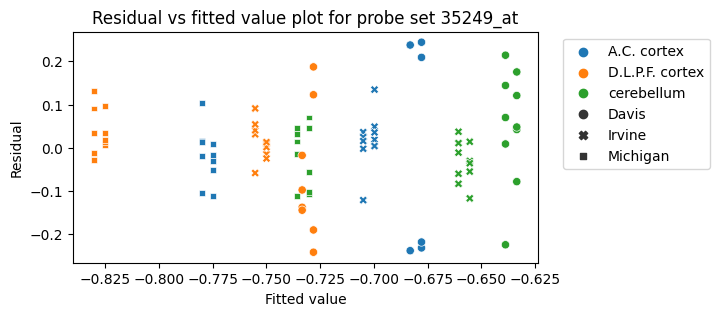

In [23]:
samples_tmp = samples.drop(columns= ["patient", "chip.version"]);
one_hot_encoding = pd.get_dummies(samples_tmp);
one_hot_encoding = one_hot_encoding.drop(columns= ["sex_female", "region_cerebellum", "lab_Davis"]);
X = sm.add_constant(one_hot_encoding);
model = sm.OLS(express_norm_samp['35249_at'],X);
results = model.fit(cov_type = 'HC3')

pred_val = results.fittedvalues.copy()
true_val = express_norm_samp['35249_at'].values.copy()
residual = true_val - pred_val

plt.figure(figsize = (6, 3))
sns.scatterplot(y=residual, x=pred_val, hue = samples['region'].values, style = samples['lab'].values)
plt.ylabel('Residual');
plt.xlabel('Fitted value');
plt.title('Residual vs fitted value plot for probe set 35249_at');
plt.legend(bbox_to_anchor=(1.04, 1))

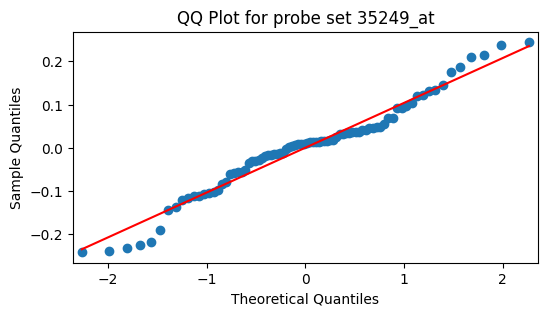

In [24]:
plt.rc("figure", figsize = (6, 3)) 
sm.qqplot(residual, line="s")
plt.title('QQ Plot for probe set 35249_at')
plt.show()

For all labs combined, we select 10 genes which have the smallest p-value corresponding to the null hypothesis $H_0: b = 0$. The table below summarizes these 10 genes. Similar to the preceding subsection, false discovery rates are controlled using the Benjamini-Hochberg (BH) procedure with $p = 0.05$, and the "BH Significant at 0.05" column indicates whether a gene is selected by the BH procedure.

Looking at the table, we also find that the majority of the identified genes are significant and belong to the sex chromosomes, specifically the Y chromosome.

In [25]:
samples_tmp = samples.drop(columns= ["patient", "chip.version"]);
one_hot_encoding = pd.get_dummies(samples_tmp);
one_hot_encoding = one_hot_encoding.drop(columns= ["sex_female", "region_cerebellum", "lab_Davis"]);
X = sm.add_constant(one_hot_encoding);

coef_gene = []
for i in range(len(genes_hum_index[:])):
  gene = genes_hum_index[i]
  model = sm.OLS(express_norm_samp[gene],X);
  results = model.fit(cov_type='HC3');
  pval = results.pvalues[1]
  coef_gene.append((gene, pval, np.abs(results.params["sex_male"])))

res = []
for gene in gene_to_probe_set:
  probes = gene_to_probe_set[gene]
  temp = [x for x in coef_gene if x[0] in probes]
  max_pval = -100
  max_pval_gene = None
  for i in temp:
    if i[1] > max_pval:
      max_pval = i[1]
      max_pval_gene = i[0]
  res.append((max_pval_gene, max_pval))

sorted_coef_gene = sorted(res, key=lambda tup: tup[1])
top10genes = [tup[0] for tup in sorted_coef_gene[:10]]

# FDR control
index_sign = np.where(multipletests([x[1] for x in res], method="fdr_bh")[0])[0]
probe_sets = np.array([x[0] for x in res])[index_sign]

In [26]:
pd.options.display.precision = 2
result_df = pd.DataFrame(columns=['Gene', 'Chromosome', 'p-value', 'BH Significant at 0.05'])
result_df['Gene'] = np.array(genes.loc[top10genes].loc[:, 'sym'].values)
result_df['Chromosome'] = np.array(genes.loc[top10genes].loc[:, 'chrom'].values)
result_df['p-value'] = np.array([x[1] for x in sorted_coef_gene[:10]])
result_df['BH Significant at 0.05'] = result_df['Gene'].apply(lambda x: x in np.array(genes.loc[probe_sets].loc[:, 'sym'].values))
print(result_df)

       Gene Chromosome   p-value  BH Significant at 0.05
0    RPS4Y1          Y  8.18e-56                    True
1     DDX3Y          Y  1.03e-21                    True
2     KDM5D          Y  7.20e-17                    True
3     USP9Y          Y  5.71e-14                    True
4      XIST          X  6.94e-13                    True
5       UTY          Y  1.61e-12                    True
6    TTTY15          Y  1.56e-07                    True
7  CYorf15B          Y  3.03e-05                    True
8    NLGN4Y          Y  1.43e-04                   False
9      CD24          6  8.67e-04                   False


We can repeat the same analysis for individual labs. For the Davis lab, we have

In [27]:
temp = express_norm_samp[express_norm_samp['lab'] == 'Davis']
samples_tmp = samples[samples['lab'] == 'Davis']
samples_tmp = samples_tmp.drop(columns= ["patient", "chip.version", "lab"]);

one_hot_encoding = pd.get_dummies(samples_tmp);
one_hot_encoding = one_hot_encoding.drop(columns= ["sex_female", "region_cerebellum"]);
X = sm.add_constant(one_hot_encoding);

coef_gene = []
for i in range(len(genes_hum_index[:])):
  gene = genes_hum_index[i]
  model = sm.OLS(temp[gene],X);
  results = model.fit(cov_type='HC3');
  pval = results.pvalues[1]
  coef_gene.append((gene, pval, np.abs(results.params["sex_male"])))

res = []
for gene in gene_to_probe_set:
  probes = gene_to_probe_set[gene]
  temp = [x for x in coef_gene if x[0] in probes]
  max_pval = -100
  max_pval_gene = None
  for i in temp:
    if i[1] > max_pval:
      max_pval = i[1]
      max_pval_gene = i[0]
  res.append((max_pval_gene, max_pval))

sorted_coef_gene = sorted(res, key=lambda tup: tup[1])
top10genes = [tup[0] for tup in sorted_coef_gene[:10]]

# FDR control
index_sign = np.where(multipletests([x[1] for x in res], method="fdr_bh")[0])[0]
probe_sets = np.array([x[0] for x in res])[index_sign]

In [28]:
print('Davis')
pd.options.display.precision = 2
result_df = pd.DataFrame(columns=['Gene', 'Chromosome', 'p-value', 'BH Significant at 0.05'])
result_df['Gene'] = np.array(genes.loc[top10genes].loc[:, 'sym'].values)
result_df['Chromosome'] = np.array(genes.loc[top10genes].loc[:, 'chrom'].values)
result_df['p-value'] = np.array([x[1] for x in sorted_coef_gene[:10]])
result_df['BH Significant at 0.05'] = result_df['Gene'].apply(lambda x: x in np.array(genes.loc[probe_sets].loc[:, 'sym'].values))
print(result_df)

Davis
     Gene Chromosome   p-value  BH Significant at 0.05
0  RPS4Y1          Y  8.54e-31                    True
1   DDX3Y          Y  1.67e-29                    True
2   USP9Y          Y  2.61e-08                    True
3     UTY          Y  1.24e-07                    True
4  TTTY15          Y  1.25e-05                    True
5    XIST          X  2.09e-05                    True
6   KDM5D          Y  9.97e-05                   False
7  NLGN4Y          Y  4.68e-04                   False
8    CD24          6  4.42e-03                   False
9  EIF1AY          Y  1.05e-02                   False


For the Irvine lab, we have

In [29]:
temp = express_norm_samp[express_norm_samp['lab'] == 'Irvine']
samples_tmp = samples[samples['lab'] == 'Irvine']
samples_tmp = samples_tmp.drop(columns= ["patient", "chip.version", "lab"]);

one_hot_encoding = pd.get_dummies(samples_tmp);
one_hot_encoding = one_hot_encoding.drop(columns= ["sex_female", "region_cerebellum"]);
X = sm.add_constant(one_hot_encoding);

coef_gene = []
for i in range(len(genes_hum_index[:])):
  gene = genes_hum_index[i]
  model = sm.OLS(temp[gene],X);
  results = model.fit(cov_type='HC3');
  pval = results.pvalues[1]
  coef_gene.append((gene, pval, np.abs(results.params["sex_male"])))

res = []
for gene in gene_to_probe_set:
  probes = gene_to_probe_set[gene]
  temp = [x for x in coef_gene if x[0] in probes]
  max_pval = -100
  max_pval_gene = None
  for i in temp:
    if i[1] > max_pval:
      max_pval = i[1]
      max_pval_gene = i[0]
  res.append((max_pval_gene, max_pval))

sorted_coef_gene = sorted(res, key=lambda tup: tup[1])
top10genes = [tup[0] for tup in sorted_coef_gene[:10]]

# FDR control
index_sign = np.where(multipletests([x[1] for x in res], method="fdr_bh")[0])[0]
probe_sets = np.array([x[0] for x in res])[index_sign]

In [30]:
print('Irvine')
pd.options.display.precision = 2
result_df = pd.DataFrame(columns=['Gene', 'Chromosome', 'p-value', 'BH Significant at 0.05'])
result_df['Gene'] = np.array(genes.loc[top10genes].loc[:, 'sym'].values)
result_df['Chromosome'] = np.array(genes.loc[top10genes].loc[:, 'chrom'].values)
result_df['p-value'] = np.array([x[1] for x in sorted_coef_gene[:10]])
result_df['BH Significant at 0.05'] = result_df['Gene'].apply(lambda x: x in np.array(genes.loc[probe_sets].loc[:, 'sym'].values))
print(result_df)

Irvine
     Gene Chromosome   p-value  BH Significant at 0.05
0  RPS4Y1          Y  9.58e-35                    True
1   DDX3Y          Y  1.17e-22                    True
2     UTY          Y  1.94e-16                    True
3   KDM5D          Y  3.57e-13                    True
4    XIST          X  1.59e-12                    True
5   USP9Y          Y  5.27e-10                    True
6   REG1P          2  8.56e-04                   False
7   APAF1         12  7.82e-03                   False
8   KIF25          6  1.20e-02                   False
9  LRRC17          7  1.25e-02                   False


Finally, for the Michigan lab, we have

In [31]:
temp = express_norm_samp[express_norm_samp['lab'] == 'Michigan']
samples_tmp = samples[samples['lab'] == 'Michigan']
samples_tmp = samples_tmp.drop(columns= ["patient", "chip.version", "lab"]);

one_hot_encoding = pd.get_dummies(samples_tmp);
one_hot_encoding = one_hot_encoding.drop(columns= ["sex_female", "region_cerebellum"]);
X = sm.add_constant(one_hot_encoding);

coef_gene = []
for i in range(len(genes_hum_index[:])):
  gene = genes_hum_index[i]
  model = sm.OLS(temp[gene],X);
  results = model.fit(cov_type='HC3');
  pval = results.pvalues[1]
  coef_gene.append((gene, pval, np.abs(results.params["sex_male"])))

res = []
for gene in gene_to_probe_set:
  probes = gene_to_probe_set[gene]
  temp = [x for x in coef_gene if x[0] in probes]
  max_pval = -100
  max_pval_gene = None
  for i in temp:
    if i[1] > max_pval:
      max_pval = i[1]
      max_pval_gene = i[0]
  res.append((max_pval_gene, max_pval))

sorted_coef_gene = sorted(res, key=lambda tup: tup[1])
top10genes = [tup[0] for tup in sorted_coef_gene[:10]]

# FDR control
index_sign = np.where(multipletests([x[1] for x in res], method="fdr_bh")[0])[0]
probe_sets = np.array([x[0] for x in res])[index_sign]

In [32]:
print('Michigan')
pd.options.display.precision = 2
result_df = pd.DataFrame(columns=['Gene', 'Chromosome', 'p-value', 'BH Significant at 0.05'])
result_df['Gene'] = np.array(genes.loc[top10genes].loc[:, 'sym'].values)
result_df['Chromosome'] = np.array(genes.loc[top10genes].loc[:, 'chrom'].values)
result_df['p-value'] = np.array([x[1] for x in sorted_coef_gene[:10]])
result_df['BH Significant at 0.05'] = result_df['Gene'].apply(lambda x: x in np.array(genes.loc[probe_sets].loc[:, 'sym'].values))
print(result_df)

Michigan
       Gene Chromosome   p-value  BH Significant at 0.05
0    RPS4Y1          Y  1.35e-25                    True
1     DDX3Y          Y  1.82e-23                    True
2     KDM5D          Y  5.24e-06                    True
3      XIST          X  1.10e-05                    True
4    TTTY15          Y  1.46e-05                    True
5       MOS          8  1.71e-05                    True
6  CYorf15B          Y  9.65e-05                   False
7      LYL1         19  2.50e-04                   False
8     USP9Y          Y  6.38e-04                   False
9     MYLPF         16  2.44e-03                   False


The table below summarizes the results from the regression models across all levels. The "# Levels" column indicates the number of levels a particular gene was identified as differentially expressed (for example, # Levels = 4 indicates that a gene is identified to be differentially expressed by all 4 regression models). Overall, we find that 7 genes (all of which are on the sex chromosomes) were identified by at least 3 models. Out of these 7 genes, 5 of them were identified by all 4 models.

In [33]:
pd.options.display.precision = 2
final_result_df = pd.DataFrame(columns=['Gene', 'Chromosome', "# Levels"])
final_result_df['Gene'] = np.array(['DDX3Y', 'RPS4Y1', 'XIST', 'KDM5D', 'USP9Y', 'TTTY15', 'UTY', 'CD24', 'CYorf15B', 'NLGN4Y'])
final_result_df['Chromosome'] = np.array(['Y', 'Y', 'X', 'Y', 'Y', 'Y', 'Y', '6', 'Y', 'Y'])
final_result_df['# Levels'] = np.array([4, 4, 4, 4, 4, 3, 3, 2, 2, 2])
print(final_result_df)

       Gene Chromosome  # Levels
0     DDX3Y          Y         4
1    RPS4Y1          Y         4
2      XIST          X         4
3     KDM5D          Y         4
4     USP9Y          Y         4
5    TTTY15          Y         3
6       UTY          Y         3
7      CD24          6         2
8  CYorf15B          Y         2
9    NLGN4Y          Y         2


### Permutation Test

In [34]:
# normalization
genes.at["AFFX-BioDn-3_at", 'chrom'] = float("Nan")
genes_control = genes[['AFFX' in s for s in genes.index]]
genes_control = genes_control[['HUM' not in s for s in genes_control.index]]
genes_control = genes_control[['hum' not in s for s in genes_control.index]]
genes_bac_index = genes_control[genes_control.chrom.isnull() & genes_control.sym.isnull()].index

genes_Y_crom = genes[genes.chrom == "Y"].index
genes_bac_index = genes[genes.sym.isnull() & genes.chrom.isnull()].index
# print(genes_bac_index.shape)
mean_bac_exp = expression[genes_bac_index].mean(axis=1)
std_bac_exp = expression[genes_bac_index].std(axis=1)
expression_norm =  (expression - mean_bac_exp.values[:, None]).divide(std_bac_exp, axis=0)
expression_qnorm = qnorm.quantile_normalize(expression, axis=0)

In [35]:
# pool all labs together
express_samp = pd.concat([expression_norm, samples], axis=1)
x_express_samp = express_samp.copy()
# group by patients
x_express_samp_new = pd.concat([
    x_express_samp.groupby('patient').mean(), 
    pd.DataFrame(columns=['perm'])
    ], axis=1)

x_express_samp_new.perm = [0,1,0,1,1,1,0,0,1,0]

x_male_mean = x_express_samp_new[x_express_samp_new.perm == 1].mean()
x_female_mean = x_express_samp_new[x_express_samp_new.perm == 0].mean()

dif = pd.DataFrame(x_male_mean - x_female_mean)
pd.set_option('mode.chained_assignment', None) # switch off the warning

for comb in combinations(range(10), 5):
    #print(comb)
    x_express_samp_new.perm = [0] * len(x_express_samp_new)

    x_express_samp_new.perm.iloc[list(comb)] = 1

    x_male_mean = x_express_samp_new[x_express_samp_new.perm == 1].mean()
    x_female_mean = x_express_samp_new[x_express_samp_new.perm == 0].mean()

    dif = pd.concat([dif, x_male_mean - x_female_mean], axis=1)
    #print(dif.shape)


We also tested the differential expression between males and females using a permutation test. This test does not rely on any modelling assumptions. For each permutation of patient sex, we compute the difference-in-means between permuted males and permuted females. Then we compare the observed value with the distribution generated by permutations and compute a two-sided p-value for each gene.

Below we show histograms of permuted outcomes of two genes `XIST` and `RPS4Y1`, located on X and Y chromosome respectively, with the corresponding observed difference-in-means. In both histograms, the observations are the most extreme among the distribution of permuted values, suggesting that there is strong evidence of those genes are differentially expressed between males and females.

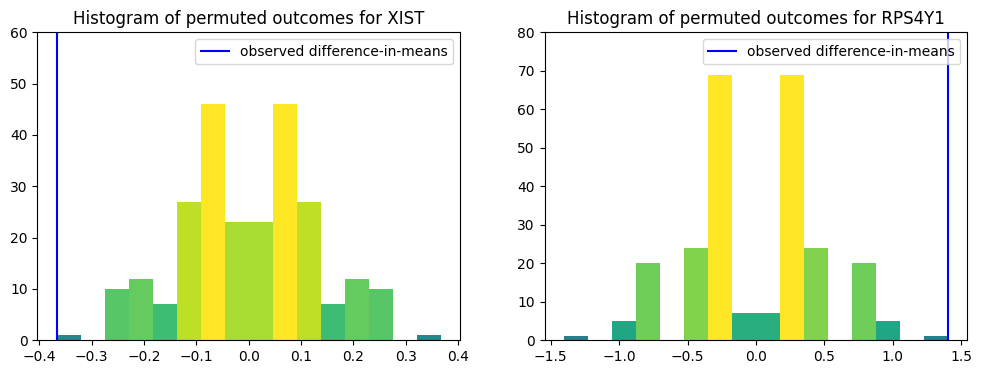

In [36]:
# plot a histogram
from matplotlib import colors

probesetXIST = genes[genes['sym'] == 'XIST'].index.values[0]
probesetRPS4 = genes[genes['sym'] == 'RPS4Y1'].index.values[0]

#print(dif.loc[probesetXIST, :].values)

fig, axs = plt.subplots(1, 2, figsize =(12, 4))

# Creating histogram
axs[0].set_ylim(top=60)
N, bins, patches = axs[0].hist(dif.loc[probesetXIST, :].values[1:], bins=16)
axs[0].axvline(x=dif.loc[probesetXIST, :].values[0], 
               color='b', label='observed difference-in-means')
axs[0].legend(loc='upper right')
 
# Setting color
fracs = ((N**(1 / 5)) / N.max())
norm = colors.Normalize(fracs.min(), fracs.max())
 
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)
    
# Creating histogram
axs[1].set_ylim(top=80)
N, bins, patches = axs[1].hist(dif.loc[probesetRPS4, :].values[1:], bins=16)
axs[1].axvline(x=dif.loc[probesetRPS4, :].values[0], 
               color='b', label='observed difference-in-means')
axs[1].legend(loc='upper right')
 
# Setting color
fracs = ((N**(1 / 5)) / N.max())
norm = colors.Normalize(fracs.min(), fracs.max())
 
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

# Adding titles   
axs[0].set_title('Histogram of permuted outcomes for XIST')
axs[1].set_title('Histogram of permuted outcomes for RPS4Y1')
 
# Show plot
plt.show()

In [37]:
# compare columns and get p-values
dif = dif.abs()
for j in range(252):
    dif.iloc[:,j+1] = dif.iloc[:,0] <= dif.iloc[:,j+1]
x_p_values = pd.DataFrame(dif.iloc[:,1:].mean(axis=1), columns=['p-value'])

x_p_values = x_p_values.drop(labels=['perm'], axis=0)
x_p_values.columns = ['p-value']
x_p_values_all = x_p_values

In [38]:
def x_get_gene_pvalues(probe_set_pval):
    '''
    pass in a dictionary with key being probeset and value being pvalue, 
    return a list of tuples (gene, pval) 
    where now p val is the max pval over all the probesets associated with that gene
    '''
    genes_sym = genes[genes.sym.notnull()]
    unique_genes = genes_sym["sym"].unique()
    gene_to_probe_set = {}

    for gene in unique_genes:
        gene_to_probe_set[gene] = genes_sym.index[genes_sym.sym == gene].tolist()

    gene_p_values = []

    for gene in genes_sym["sym"].unique():
        gene_p = 0
        gene_probes = gene_to_probe_set[gene]
        for probe in gene_probes:
            gene_p = max(gene_p, probe_set_pval[probe])
        gene_p_values.append((gene_p, gene))
    return gene_p_values

In [39]:
x_max_p_values_all = x_get_gene_pvalues(x_p_values_all.to_dict()['p-value'])
x_max_p_values_all = pd.DataFrame(x_max_p_values_all, columns=['p-value', 'sym'])

x_threshold = 0.05

p_values = x_max_p_values_all
x_df_all = p_values[p_values['p-value'] <= x_threshold].sort_values(by=['p-value'], axis=0)

Since the sample consists of 5 males and 5 females, the number of permutations we can consider is $\binom{10}{5}=252$, and the minimum possible p-value is $2/252 \approx 0.79\%$ because the test is two-sided. For this reason, when performing the Benjamini-Hochberg approach to adjust for the p-value, we do not get any rejection of the null hypothesis at the level 0.05, so we omit the BH significance result in this section. First we pool the data together and run the permutation test. Genes with the most significant differential expressions are shown in the following table (no particular order). Note that there are 9 genes located on sex chromosomes among the 12 most significant genes.

In [40]:
x_sig_genes = x_df_all[x_df_all['p-value'] < 0.008]
x_chrom_all = []

for g in x_sig_genes.sym:
    # print(g, genes[genes['sym'] == g].iloc[0,1])
    x_chrom_all.append(genes[genes['sym'] == g].iloc[0,1])

x_sig_genes.insert(2, 'chrom', x_chrom_all, True)
# print(x_sig_genes[['sym', 'chrom', 'p-value']].round(4).to_markdown(index=False))
x_df_output = (x_sig_genes[['sym', 'chrom', 'p-value']]
.rename(columns={'sym': 'Gene', 'chrom': 'Chromosome'})
.round(4))
# x_df_output['Significant'] = ['True'] * 12
print(x_df_output.reset_index().iloc[:,1:])

       Gene Chromosome   p-value
0     USP9Y          Y  7.90e-03
1    RPS4Y1          Y  7.90e-03
2    MBTPS2          X  7.90e-03
3    EIF1AY          Y  7.90e-03
4      XIST          X  7.90e-03
5     DDX3Y          Y  7.90e-03
6   ANKRD26         10  7.90e-03
7     KDM5D          Y  7.90e-03
8   KAZALD1         10  7.90e-03
9    TTTY15          Y  7.90e-03
10   ADAM28          8  7.90e-03
11      UTY          Y  7.90e-03


In [41]:
x_express_samp_UM = express_samp[express_samp.lab == "Michigan"]

# group by patients
x_express_samp_UM_new = pd.concat([
    x_express_samp_UM.groupby('patient').mean(), 
    pd.DataFrame(columns=['perm'])
    ], axis=1)

x_express_samp_UM_new.perm = [0,1,0,1,1,1,0,0,1,0]

x_male_mean = x_express_samp_UM_new[x_express_samp_UM_new.perm == 1].mean()
x_female_mean = x_express_samp_UM_new[x_express_samp_UM_new.perm == 0].mean()

dif = pd.DataFrame(x_male_mean - x_female_mean)
pd.set_option('mode.chained_assignment', None) # switch off the warning

for comb in combinations(range(10), 5):
    #print(comb)
    x_express_samp_UM_new.perm = [0] * len(x_express_samp_UM_new)

    x_express_samp_UM_new.perm.iloc[list(comb)] = 1

    x_male_mean = x_express_samp_UM_new[x_express_samp_UM_new.perm == 1].mean()
    x_female_mean = x_express_samp_UM_new[x_express_samp_UM_new.perm == 0].mean()

    dif = pd.concat([dif, x_male_mean - x_female_mean], axis=1)
    #print(dif.shape)


In [42]:
# compare columns and get p-values
dif = dif.abs()
for j in range(252):
    dif.iloc[:,j+1] = dif.iloc[:,0] <= dif.iloc[:,j+1]
x_p_values = pd.DataFrame(dif.iloc[:,1:].mean(axis=1), columns=['p-value'])

x_p_values = x_p_values.drop(labels=['perm'], axis=0)
x_p_values.columns = ['p-value']
x_p_values_m = x_p_values

In [43]:
x_express_samp_Ir = express_samp[express_samp.lab == "Irvine"]

# group by patients
x_express_samp_Ir_new = pd.concat([
    x_express_samp_Ir.groupby('patient').mean(), 
    pd.DataFrame(columns=['perm'])
    ], axis=1)

x_express_samp_Ir_new.perm = [0,1,0,1,1,1,0,0,1,0]

x_male_mean = x_express_samp_Ir_new[x_express_samp_Ir_new.perm == 1].mean()
x_female_mean = x_express_samp_Ir_new[x_express_samp_Ir_new.perm == 0].mean()

dif = pd.DataFrame(x_male_mean - x_female_mean)
pd.set_option('mode.chained_assignment', None) # switch off the warning

for comb in combinations(range(10), 5):
    #print(comb)
    x_express_samp_Ir_new.perm = [0] * len(x_express_samp_Ir_new)

    x_express_samp_Ir_new.perm.iloc[list(comb)] = 1

    x_male_mean = x_express_samp_Ir_new[x_express_samp_Ir_new.perm == 1].mean()
    x_female_mean = x_express_samp_Ir_new[x_express_samp_Ir_new.perm == 0].mean()

    dif = pd.concat([dif, x_male_mean - x_female_mean], axis=1)
    #print(dif.shape)

In [44]:
# compare columns and get p-values
dif = dif.abs()
for j in range(252):
    dif.iloc[:,j+1] = dif.iloc[:,0] <= dif.iloc[:,j+1]
x_p_values = pd.DataFrame(dif.iloc[:,1:].mean(axis=1), columns=['p-value'])

x_p_values = x_p_values.drop(labels=['perm'], axis=0)
x_p_values.columns = ['p-value']
x_p_values_i = x_p_values

In [45]:
x_express_samp_Da = express_samp[express_samp.lab == "Davis"]

# group by patients
x_express_samp_Da_new = pd.concat([
    x_express_samp_Da.groupby('patient').mean(), 
    pd.DataFrame(columns=['perm'])
    ], axis=1)

x_express_samp_Da_new.perm = [0,1,0,1,1,1,0,0,1,0]

x_male_mean = x_express_samp_Da_new[x_express_samp_Da_new.perm == 1].mean()
x_female_mean = x_express_samp_Da_new[x_express_samp_Da_new.perm == 0].mean()

dif = pd.DataFrame(x_male_mean - x_female_mean)
pd.set_option('mode.chained_assignment', None) # switch off the warning

for comb in combinations(range(10), 5):
    #print(comb)
    x_express_samp_Da_new.perm = [0] * len(x_express_samp_Da_new)

    x_express_samp_Da_new.perm.iloc[list(comb)] = 1

    x_male_mean = x_express_samp_Da_new[x_express_samp_Da_new.perm == 1].mean()
    x_female_mean = x_express_samp_Da_new[x_express_samp_Da_new.perm == 0].mean()

    dif = pd.concat([dif, x_male_mean - x_female_mean], axis=1)
    #print(dif.shape)

In [46]:
# compare columns and get p-values
dif = dif.abs()
for j in range(252):
    dif.iloc[:,j+1] = dif.iloc[:,0] <= dif.iloc[:,j+1]
x_p_values = pd.DataFrame(dif.iloc[:,1:].mean(axis=1), columns=['p-value'])

x_p_values = x_p_values.drop(labels=['perm'], axis=0)
x_p_values.columns = ['p-value']
x_p_values_d = x_p_values

In [47]:
x_max_p_values_m = x_get_gene_pvalues(x_p_values_m.to_dict()['p-value'])
x_max_p_values_m = pd.DataFrame(x_max_p_values_m, columns=['p-value', 'sym'])

x_max_p_values_i = x_get_gene_pvalues(x_p_values_i.to_dict()['p-value'])
x_max_p_values_i = pd.DataFrame(x_max_p_values_i, columns=['p-value', 'sym'])

x_max_p_values_d = x_get_gene_pvalues(x_p_values_d.to_dict()['p-value'])
x_max_p_values_d = pd.DataFrame(x_max_p_values_d, columns=['p-value', 'sym'])

p_values = x_max_p_values_m
x_df_m = p_values[p_values['p-value'] <= x_threshold].sort_values(by=['p-value'], axis=0)
p_values = x_max_p_values_i
x_df_i = p_values[p_values['p-value'] <= x_threshold].sort_values(by=['p-value'], axis=0)
p_values = x_max_p_values_d
x_df_d = p_values[p_values['p-value'] <= x_threshold].sort_values(by=['p-value'], axis=0)

We applied the permutation test to each of the 3 labs to see if results are consistent across lab replications. The following table shows p-values of the genes that show evidence of differential expression (have a p-value less than 4\%) in at least 2 labs. There are 9 genes located on sex chromosomes among the 12 genes. Taking an intersection with the genes shown in the previous table, we find genes `DDX3Y`, `KDM5D`, `RPS4Y1`, `XIST`, `USP9Y`, `UTY`, `TTTY15`, and `EIF1AY` show greatest statistical significance in the permutation test.

In [48]:
x_comb = (x_df_m[['sym', 'p-value']]
 .merge(x_df_i, how='outer', on='sym', suffixes=(' Michigan', ' Irvine'))
 .merge(x_df_d, how='outer', on='sym')
).rename(columns={'p-value': 'p-value Davis'})

x_sig_genes2 = (x_comb.reindex(x_comb.iloc[:,1:].fillna(value=1).mean(axis=1).sort_values().index)
 .iloc[:12,:].round(4)
)

x_chrom_lab = []

for g in x_sig_genes2.sym:
    # print(g, genes[genes['sym'] == g].iloc[0,1])
    x_chrom_lab.append(genes[genes['sym'] == g].iloc[0,1])

x_sig_genes2.insert(1, 'chrom', x_chrom_lab, True)
# print(x_sig_genes2.to_markdown(index=False))

x_df_output2 = (x_sig_genes2
.rename(columns={'sym': 'Gene', 'chrom': 'Chromosome'})
.round(4))
pd.options.display.precision = 4
print(x_df_output2.reset_index().iloc[:,1:].fillna(value=">0.05"))
pd.options.display.precision = 2

        Gene Chromosome p-value Michigan p-value Irvine p-value Davis
0       XIST          X           0.0079         0.0079        0.0079
1     RPS4Y1          Y           0.0079         0.0079        0.0079
2      KDM5D          Y           0.0079         0.0079        0.0079
3      DDX3Y          Y           0.0079         0.0079        0.0079
4        UTY          Y           0.0238         0.0079        0.0079
5      USP9Y          Y           0.0238         0.0079        0.0079
6     TTTY15          Y           0.0079         0.0317        0.0079
7      FABP7          6           0.0397         0.0397        0.0317
8     EIF1AY          Y            >0.05         0.0159        0.0079
9       LRBA          4           0.0317          >0.05        0.0079
10  CYorf15B          Y           0.0317         0.0238         >0.05
11     SR140          3           0.0159         0.0397         >0.05


### Recommendations

Based on the results of our three methods, we give our recommendations. The first tier of genes are `RPS4Y1`, `DDX3Y`, `XIST`, `KDM5D`, and `USP9Y`. Gene `XIST` is on X chromosome while the other four are on Y chromosome. This tier of genes appear to show statistically significant differential expression between males and females consistently across all methods and across different conditions. Accordingly, we are very confident in them with respect to the reliability of the result. The second tier of genes are `TTTY15` and `UTY`, which are located on the Y chromosome. They show statistical significance in two of the three methods. We recommend investigating in these genes if budget permits in future studies. 

| Tier     | Genes   |   Number of methods that identify them 
|:--------|:--------:|:----------:|
| 1  | `RPS4Y1`, `DDX3Y`, `XIST`, `KDM5D`, `USP9Y`       |    3 
| 2  | `TTTY15`, `UTY`       |    2 |

### Reliability of Findings

Using the three axes of reliability mentioned previously, we find that our recommendations for this task to be generally reliable. In all of our tests, the p-value is taken as the maximum over all probe sets that correspond to the gene, so our result is robust against volatility among probe sets in a conservative way. Since recommended genes show highest statistical significance accross all methods, which are based on different underlying assumptions and come from perspectives, we believe their consensus is reliable and almost conservative. We also examined the consistency of the data across brain regions and labs using different methods, which proves that the study has good replicability. For every method, there are a large proportion of sex-related genes among the identified genes, particularly the genes that are on the Y chromosome. This matches with our biological intuition, suggesting that our findings are reliable. 

Nonetheless, there could be potential limitations. For the KS test, male and female samples at lab and tissue level are not i.i.d. For regression, the models might not be well-specified. For the permutation test, the p-value might not be precise enough due to the limitation of sample size. 

## Differential Expression between Tissue Regions


In this section, we discuss how genes are differentially expressed in different regions of the brain. Mainly, we focus on two areas the *dorsolateral prefrontal cortex* (DLPFC) and the *anterior cingulate cortex* (ACC). To contrast this investigation from that of the previous section, we begin by noting that it is, in fact, possible to study the individual-level effect of brain region as opposed to just the population-level effect we studied for sex. This is true because we have the measurement of gene expression in both DLPFC as well as ACC for the same individual. However, the goal of our analysis is to investigate how genes are differentially expressed in these two brain regions on a population level, and thus we will still focus on the aggregate statistics of measurements across all individuals. 

For each probe set $p$ and an individual, let us denote a random vector $(A_p, D_p)$ to be the gene expression in ACC and DLPFC respectively. Define $\Delta_{ p} := D_{p} - A_{p}$ to be the difference in expression between these two regions for gene associated to probe set $p$. We study the mean difference, $\mathbb{E}(\Delta_p)$, and the median difference, $\text{Median}(\Delta_p)$, to quantify the differential expression between two regions across the population. In general, if the magnitude of these quantities is large, we can conclude that the gene corresponding to the probe set $p$ is expressed differently in these two regions. To make our inference more rigorous, we use paired t-test and Wilcoxon rank test. Note that the null hypothesis of paired t-test is $H_0: \mathbb{E}(\Delta_p) = 0$, whereas that of Wilcoxon rank test is $H_0: \text{Median}(\Delta_p) = 0$ in this context. We will provide more details on these tests in the following subsection. For the convenience of exposition in following subsections, we will use  $\{(A_{p, i}, D_{p, i})\}_{i=1}^{10}$ to denote the gene expression in ACC and DLPFC respectively for probe set $p$ and individual $i$. As before, let us define the corresponding difference to be $\Delta_{i, p} := D_{p, i} - A_{p, i}$ to be for the pair $(p,i)$. 

Finally, we assess the reliability of our findings primarily through the replicability of our analysis and conclusion across Michigan and Irvine labs. Note that we discard Davis data for this analysis because for every probe set $p$, either the measurement of $A_{p, i}$ or $D_{p, i}$ is missing for $6$ individuals in the Davis lab. Unfortunately, our analysis yielded different conclusions across Michigan and Irvine labs, thereby reducing the reliability of our findings. The primary reason for this replicability issue is the lab level and microarray level variation that we could not adjust for. We will discuss these unwanted variations in more detail later in the report.

We note that the analysis is done on the bacteria-normalized data. We also applied the same scheme of computing the p-value for each gene from the previous section.

(-1.0, 1.5)

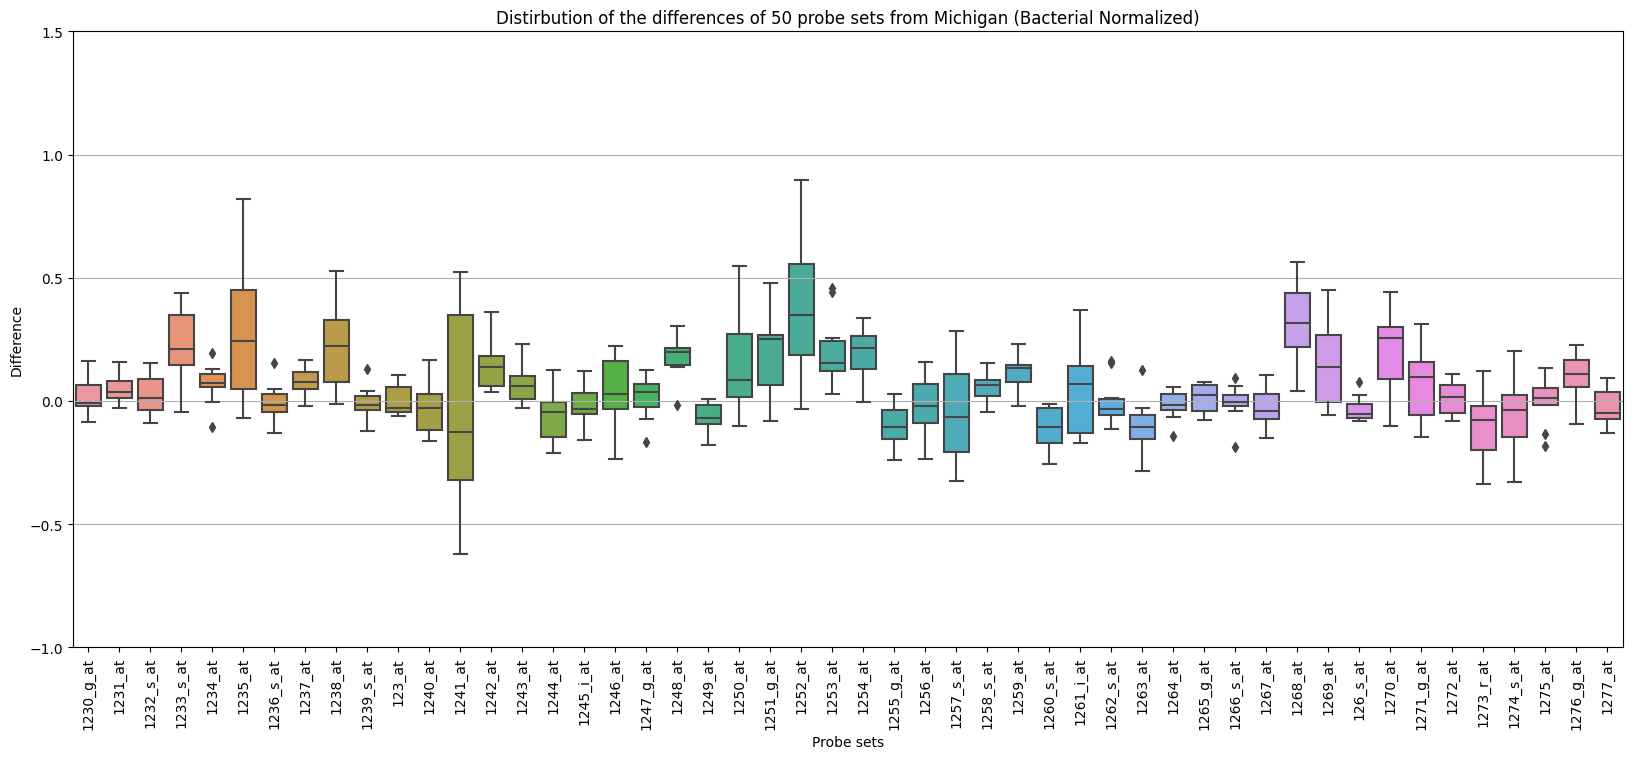

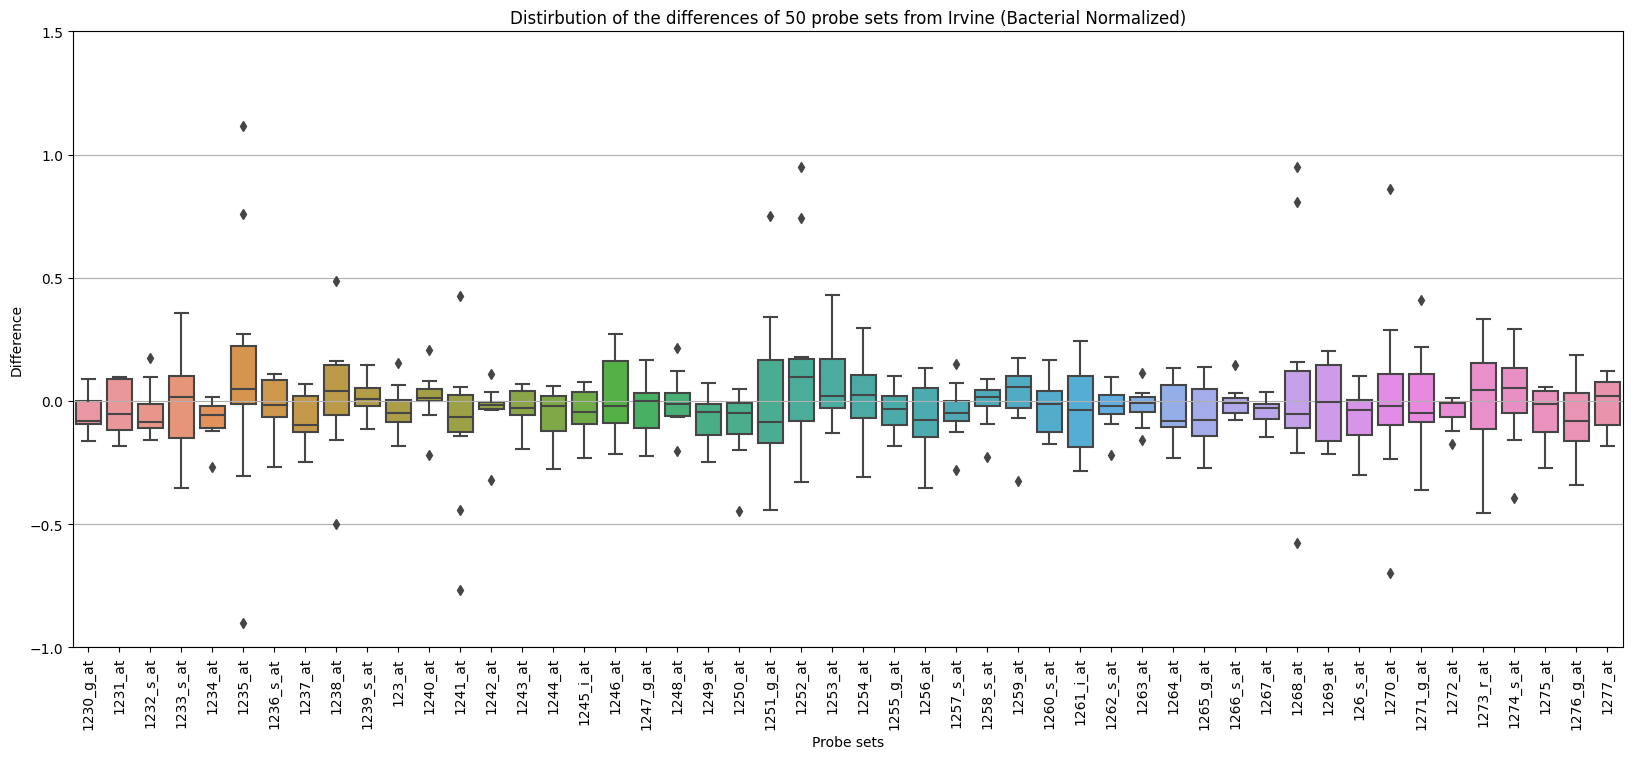

In [49]:
# Data Preparation
# Select bacterial controls
genes.at["AFFX-BioDn-3_at", 'chrom'] = float("Nan")
genes_control = genes[['AFFX' in s for s in genes.index]]
genes_control = genes_control[['HUM' not in s for s in genes_control.index]]
genes_control = genes_control[['hum' not in s for s in genes_control.index]]
genes_bac_index = genes_control[genes_control.chrom.isnull() & genes_control.sym.isnull()].index

# Bacterial Normalization
mean_bac_exp = expression[genes_bac_index].mean(axis=1)
std_bac_exp = expression[genes_bac_index].std(axis=1)
expression_norm =  (expression - mean_bac_exp.values[:, None]).divide(std_bac_exp, axis=0)

# Michigan
michigan = expression_norm[(expression.index.str[5] == 'M') & (expression.index.str[3] != 'c') ]
michigan_diff = michigan.diff().iloc[1::2,:]
michigan_diff.index = "patient" + michigan_diff.index.str[:2]
#michigan_diff

# Davis
davis = expression_norm[(expression.index.str[5] == 'D') & (expression.index.str[3] != 'c') ]
davis = davis[~davis.index.str[1].isin(['1', '2', '5', '6', '7', '9'])]
davis_diff = davis.diff().iloc[1::2,:]
davis_diff.index = "patient" + davis_diff.index.str[:2]
#davis

# Irvine
irvine = expression_norm[(expression.index.str[5] == 'I') & (expression.index.str[3] != 'c') ]
irvine_diff = irvine.diff().iloc[1::2,:]
irvine_diff.index = "patient" + irvine_diff.index.str[:2]

plt.figure(figsize=(20, 8))
plt.grid()
sns.boxplot(data=michigan_diff.iloc[:, 250:300])
plt.title('Distribution of the differences of 50 probe sets from Michigan (bacteria-normalized)')
plt.ylabel('Difference')
plt.xlabel('Probe sets')
plt.xticks(rotation=90)
plt.ylim((-1, 1.5))

plt.figure(figsize=(20, 8))
plt.grid()
sns.boxplot(data=irvine_diff.iloc[:, 250:300])
plt.title('Distribution of the differences of 50 probe sets from Irvine (bacteria-normalized)')
plt.ylabel('Difference')
plt.xlabel('Probe sets')
plt.xticks(rotation=90)
plt.ylim((-1, 1.5))

### Hypothesis Testing

We investigated the differential gene expression between the two brain regions using paired t-test and Wilcoxon signed-rank test. We studied the paired difference due to the nature of the data collection; for each individual, we have the measurement of gene expression in both DLPFC and ACC. A paired t-test is a parametric testing procedure that tests whether the population mean of the differences is 0 or not. It assumes the paired differences follow the normal distribution. On the other hand, Wilcoxon signed-rank test is a nonparametric version of the paired t-test that tests on the median of the differences from a symmetric distribution.

In order to do Wilcoxon signed-rank test for each probe set $p$, we first order the absolute values of the differences in an ascending order and assign rank, $R_{i,p}$. For the two-sided test, we compute the following: $W_p^+ = \sum_{i, \Delta_{i,p} > 0} R_{i,p}$, $W_p^- = \sum_{i, \Delta_{i,p} < 0} R_{i,p}$, and $W_p = \min(W_p^+, W_p^-)$. Under the null, $W_p^+$ and $W_p^-$ will have similar values. Here $W_p$ is the test statistic and we compare it with the null distribution to compute the p-value. 

The analysis was done separately on Michigan and Irvine lab. We took this approach as non-negligible lab effects exhibit in the paired differences distribution for each probe set as can be seen in the boxplots presented in the introduction of this section. Thus, performing the tests on the aggregated data was not appropriate. We performed both tests(two-sided hypothesis testing) for each probe set and attained p-value for the corresponding gene. We then identified significant genes by controlling false discovery rate with $p=0.05$ using the Benjamini-Hochberg correction. To begin with, Michigan and Irvine labs yielded different results. None of the genes were shown to be significant from Irvine lab regardless of which method we use. On the other hand, both methods identified approximately 2,000 significant genes out of 8,573 genes from Michigan lab. 

| Lab       | Tests                     |  # of rejected H0 |
| --------- | --------------------------|-------------------|
| Irvine    | Wilcoxon signed-rank test |0
|           | Paired t-test             |0
| Michigan  | Wilcoxon signed-rank test |1875
|           | Paired t-test             |2099


Moreover, we observed inconsistent results between methods as well. We studied the top 50 genes (genes with the lowest p-values) from both methods from Michigan lab and only 4 genes (`VASH1`, `FAM32A`, `F8`, `DLG4`) overlapped. To summarize, we were not able to replicate the analysis results across methods and labs. The inconsistency of the results made us question the reliability that will be discussed later.




In [50]:
from scipy.stats import wilcoxon
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests

def get_gene_pvalues(probe_set_pval):
  '''
  Outputs the p-values for each 'gene'.
  For each gene, there could be multiple corresponding probesets. We take the maximum value of the p-values for the gene p-value
  '''
  unique_genes = genes_u.sym.unique()

  # Match probeset to the gene
  gene_to_probe_set = {}
  for gene in unique_genes:
    gene_to_probe_set[gene] = genes_u.index[genes_u.sym == gene].tolist()
  
  # Get the gene_pvalues(highest p-value among all the probesets)
  gene_p_values = pd.Series()

  # Iterate over genes:
  for gene in unique_genes:
    gene_p = 0
    gene_probes = gene_to_probe_set[gene]
    # For each probe from a gene
    for probe in gene_probes:
      gene_p = max(gene_p, probe_set_pval[probe])

    gene_p_values[gene] = gene_p

  return gene_p_values


def testing(df, lab, mode):
  
  '''
  do Wilcoxon signed-rank test/paired t-test for each gene. 
  Make either Bonferroni or Benjamini-Hochberg correction when doing the multiple testing

  args:
  -----
  df: data frame without the controls
  lab: should be one of 'michigan', 'irvine', 'davis'
  mode: 'w' if Wilcoxon-signed-rank test, 't' if paired t-test
  '''

  if (mode=='w'):
    p_val = df.apply(wilcoxon).iloc[1,:]

  else:
    p_val = pd.Series([ttest_1samp(df.iloc[:,i], 0)[1] for i in np.arange(df.shape[1])], index=df.columns)

  # Convert probeset p-values to gene p-values
  p_val = get_gene_pvalues(p_val)

  # Multiple hypothesis testing
  bonferr = pd.Series(multipletests(p_val, method='bonferroni', alpha=0.05)[1], index=p_val.index)
  bh = pd.Series(multipletests(p_val, method='fdr_bh', alpha=0.05)[1], index=p_val.index)

  # Storing
  pvals['_'.join([lab, mode])] = p_val
  rejected['_'.join([lab, mode])+'_b'] = bonferr 
  rejected['_'.join([lab, mode])+'_bh'] = bh  


# `pvals` stores the pvalues, `rejected` stores the rejected H0 from the multiple hypothesis testing
pvals = {}
rejected = {}

# Genes that should be used
genes_u = genes[~pd.isna(genes.sym)]
genes_u = genes_u[['AFFX' not in s for s in genes_u.index]]

# Remove controls, and select genes with symbols
michigan_diff = michigan_diff[genes_u.index]
irvine_diff = irvine_diff[genes_u.index]

testing(michigan_diff, 'Michigan', 'w')
testing(irvine_diff, 'Irvine', 'w')
testing(michigan_diff, 'Michigan', 't')
testing(irvine_diff, 'Irvine', 't')

# Summary of the tests
t = pd.DataFrame(columns=['Lab', 'Test', 'Correction', 'Rejected'])
for key in rejected:
  k = key.split('_')
  lab = k[0]
  test = k[1]
  corr = k[2]
  rej = sum(rejected[key] < 0.05)
  r = dict({'Lab': lab, 'Test':test, 'Correction':corr, 'Rejected':rej})
  t = pd.concat([t,pd.DataFrame(r, index=[0])])
#t.sort_values('Lab')

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


The following are the genes that we recommend for the confirmatory analysis. We selected these genes from the paired t-test results from both Michigan and Irvine labs. We first selected 250 genes with the lowest p-values from each lab and selected the ones that overlapped. We decided to use paired t-test results because the magnitude of the p-values matter in the gene selection. Many of the p-values from Wilcoxon signed-rank test have the same value since it only accounts for the relative signed rank instead of the actual magnitude of the differences. Furthermore, many of the probe sets violate the symmetricity assumption of the Wilcoxon signed-rank test. As a closing remark, this recommendation is not reliable since we had inconsistent analysis results across testing procedures and labs.



In [51]:
'''
Gene selection:  
1) select top 250 genes from both michigan and irvine lab.   
2) select the genes that overlap
'''

pd.options.display.float_format = '{:.1e}'.format
# Gene selection from michigan and irvine
m = pvals['Michigan_t'].sort_values()
m = m.iloc[:250]

i = pvals['Irvine_t'].sort_values()
i = i.iloc[:250]

s = m.reset_index().merge(i.reset_index(), on='index').sort_values('0_x')
s = s.merge(genes, left_on='index', right_on='sym')
s = s.filter(['index', 'chrom', '0_x', '0_y'])
s.columns = ['Gene', 'Chromosome', 'p-value (Michigan)', 'p-value (Irvine)']

#sm = rejected['Michigan_t_bh'][s.Gene]
#sm = [True if i<0.05 else False for i in sm]

#si = rejected['Irvine_t_bh'][s.Gene]
#si = [True if i<0.05 else False for i in si]

#s['BH Significant at 0.05(Michigan)'] = sm
#s['BH Significant at 0.05(Irvine)'] = si
print(s)

        Gene Chromosome  p-value (Michigan)  p-value (Irvine)
0      RAB36         22             9.0e-06           2.0e-02
1     ZNF862          7             9.5e-06           1.5e-02
2       CHD1          5             1.5e-05           1.8e-02
3  LOC283079         10             5.3e-05           1.4e-02
4      INSM1         20             5.5e-05           1.4e-02
5       LRP6         12             6.2e-05           1.7e-02
6     ERLIN1         10             7.0e-05           1.8e-02


### Reliability of Findings

As mentioned earlier, we believe that our findings are generally unreliable. The primary factor that deems our findings unreliable is the irreplicablity of our analysis and conclusion across Michigan and Irvine labs. Secondly, the fact that different methods give completely different results makes our findings questionable. It is common knowledge that any method based on mean (like t-test) is prone to outliers and may lead to wrong conclusions. However, even the Wilcoxon rank test which is based on the median and considered relatively robust to outliers failed to replicate findings across two labs. This leads us to conclude that the unreliability here is more of an artifact of the data than the method itself. More precisely, the unaccounted variations (both lab level and microarray level) are the primary source of uncertainty in our findings. We tried different normalization schemes to adjust this variability but to no avail. In fact, as a further testament to the unreliability of our findings, we observed that our results are highly sensitive to even a small change in the normalization scheme. 

Our inability to replicate the findings across two labs are aided by various factors. First of all, in many cases, the data suggests contradictory account. For many pairs $(p, i)$, we observe that $\Delta_{p, i} > 0$ for Michigan lab but $\Delta_{p, i} < 0$ for Irvine lab. To illustrate this rather contradictory observation, let us look at the average $\overline{\Delta}_p$, where the average is taken across measurements of individuals within the lab. 

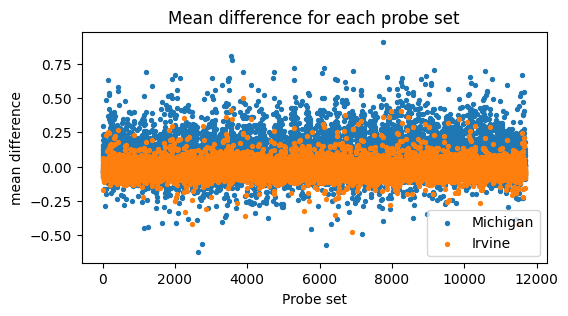

In [52]:

m = michigan_diff.mean(axis =0)
i = irvine_diff.mean(axis =0)
plt.figure(figsize=(6, 3), dpi=100)
g1 = plt.scatter(range(len(m)), m, s = 8, label = "Michigan" )
g2 = plt.scatter(range(len(i)), i, s= 8, label = "Irvine")
plt.title("Mean difference for each probe set")
plt.xlabel("Probe set")
plt.ylabel("Mean difference")
plt.legend()
plt.show()


We can observe in the figure above that most of the average difference is slightly below $0$ for Irvine lab, whereas more of those are positive for Michigan lab. The signs of $\overline{\Delta}_p$ are different for Irvine and Michigan labs for $5,857$ probe sets. There could be various reasons for this flipping of signs. One justification we propose is based on the following additive decomposition, $\Delta_{p, i} = \delta_{p, i} + \epsilon_{p, i} $, where $\delta_{p, i}$ is the true difference, signal,  and $\epsilon_{p, i}$ is the noise introduced by other exogenous factors like lab conditions, microarray level measurement noise, or any other source of experimental corruption. It is clear from the data that the true difference in expression between DLPFC and ACC if any is pretty small. Thus, it is likely that the magnitude of the noise is in the same order as the signal $|\epsilon_{p, i}| \approx |\delta_{p, i}|$ such that the sign of $\Delta_{p, i}$ is different than that of $\delta_{p, i}$, leading to wrong conclusions. This 'noise dominating the signal hypothesis' is strongly supported by high variability in measurements in the Michigan lab compared to that of the Irvine lab as shown in the figure above. In fact, one major source of variation in Michigan lab's data is chip version: for 6 individuals, the measurement of ACC is taken using chip version 1 whereas that of DLPFC is taken using chip version 2. Of course, there are other sources of variations as well, but the variation introduced by the chip version is obviously strong. Finally, we want to point out that if we can identify all the sources of variations $\epsilon_{p, i}$ and adjust for that to recover actual $\delta_{p, i}$, then it could be possible to replicate results across both labs.  




## Conclusion

To reiterate our findings, we observed that sex has statistically significant effect on gene expression. Based on our analysis, we recommend that the following genes be further investigated for the confirmatory analysis:

 (a) [Tier 1] `RPS4Y1`, `DDX3Y`, `XIST`, `KDM5D`, `USP9Y`
 (b) [Tier 2] `TTTY15`, `UTY`
 
Tier 1 recommendations have less uncertainty compared to tier 2 ones. Thus, we suggest running a confirmatory analysis for tier 1 recommendations first and then running that for tier 2 recommendations if budget constraints allow. We believe that our recommendations are pretty reliable mainly for two reasons. First, most of our recommendations are genes associated with sex chromosomes, which is corroborated by basic human biology. Secondly, our results are consistent across the wide range of methods we tried. Nevertheless, our analysis could still be plagued by  model misspecification and data not satisfying the assumptions required for the methods we used.  

On the other hand, the story is different for brain regions. The tissue effect, if exists, is weak both in an absolute sense and in a relative sense compared to the sex effect. For many probe sets/individuals, the unwanted variations (measurement noise, broadly) are large enough to dominate the tissue effect. In presence of such variations that we could not completely adjust for, our conclusion for tissue effect is less reliable. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ed989d85-0656-4309-bb63-fdbb7b58fae2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>